In [28]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import math
import glob
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

In [30]:
# % Used Smartphone: LGE-lge-LG-H815-5.1                                             
# % Smartphone's Accelerometer: LGE Accelerometer - Vendor: BOSCH                    
# % --> Version: 1                                                                   
# % --> Min - Max Delay: 5000us - 65535000us                                         
# % --> Maximum Range: 16.000000263891405 G                                          
# % --> Resolution: 1.2136514986004396E-4 G                                          
                                                                                    
# % SensorTag's Accelerometer: MPU-9250 MEMS MotionTracking Device - Invensense      
# % --> Maximum Range: 16 G                                                          
# % --> Resolution: 0.00024 G                                                        
                                                                                    
# % MAC Address; Sensor_ID; Position; Device Model                                   
# %f8:95:c7:f3:ba:82; 0; RIGHTPOCKET; lge-LG-H815-5.1                                
# %C4:BE:84:70:64:8A; 1; CHEST; SensorTag                                            
# %C4:BE:84:70:0E:80; 3; WRIST; SensorTag                                            
# %C4:BE:84:71:A5:02; 2; WAIST; SensorTag                                            
# %B0:B4:48:B8:77:03; 4; ANKLE; SensorTag                                            
                                                                                    
# % Sensor_Type:                                                                     
# % Accelerometer = 0                                                                
# % Gyroscope = 1                                                                    
# % Magnetometer = 2  

In [31]:
datapath = "../CAGE/data/UMAFall_Dataset/"
all_files = glob.glob(os.path.join(datapath, "*.csv"))

In [32]:
def parse_filename(filename):
    pattern = r'UMAFall_Subject_(\d+)_(ADL|Fall)_([a-zA-Z_]+)_(\d+)_(\d{4}-\d{2}-\d{2})_.*\.csv'
    match = re.match(pattern, filename)
    
    if match:
        subject_id = int(match.group(1))
        activity_type = match.group(2)
        activity = match.group(3)
        trial = int(match.group(4))
        date = match.group(5)
        return subject_id, activity_type, activity, trial, date
    return None

In [33]:
def read_all_sensors_file(filepath):
    sensor_data = {
        'RIGHTPOCKET': {'id': None, 'data': []},
        'CHEST': {'id': None, 'data': []},
        'WRIST': {'id': None, 'data': []},
        'WAIST': {'id': None, 'data': []},
        'ANKLE': {'id': None, 'data': []}
    }
    
    with open(filepath, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if ';' in line and any(pos in line for pos in sensor_data.keys()):
                parts = line.strip().split(';')
                if len(parts) >= 3:
                    sensor_id = parts[1].strip()
                    position = parts[2].strip()
                    if position in sensor_data:
                        sensor_data[position]['id'] = sensor_id
        
        data_start = False
        for line in lines:
            if '% TimeStamp; Sample No;' in line:
                data_start = True
                continue
            
            if data_start:
                try:
                    values = [float(v.strip()) for v in line.split(';')]
                    sensor_id = str(int(values[-1]))
                    sensor_type = int(values[-2])
                    data = values[2:5]
                    
                    for position, info in sensor_data.items():
                        if info['id'] == sensor_id:
                            info['data'].append([*data, sensor_type])
                except:
                    continue
    
    for position in sensor_data:
        if sensor_data[position]['data']:
            sensor_data[position]['data'] = np.array(sensor_data[position]['data'])
        else:
            sensor_data[position]['data'] = None
            
    return sensor_data

In [34]:
def process_sensor_data(sensor_data):
    processed_data = {}
    valid_lengths = []
    
    for position, data in sensor_data.items():
        if data['data'] is not None:
            acc_mask = data['data'][:, -1] == 0
            gyro_mask = data['data'][:, -1] == 1
            mag_mask = data['data'][:, -1] == 2
            
            acc_data = data['data'][acc_mask][:, :3] if np.any(acc_mask) else np.array([])
            gyro_data = data['data'][gyro_mask][:, :3] if np.any(gyro_mask) else np.array([])
            mag_data = data['data'][mag_mask][:, :3] if np.any(mag_mask) else np.array([])
            
            if len(acc_data) > 0:
                valid_lengths.append(len(acc_data))
            if len(gyro_data) > 0:
                valid_lengths.append(len(gyro_data))
            if len(mag_data) > 0:
                valid_lengths.append(len(mag_data))
    
    if not valid_lengths:
        return None
        
    min_length = min(valid_lengths)
    
    for position, data in sensor_data.items():
        if data['data'] is not None:
            acc_mask = data['data'][:, -1] == 0
            gyro_mask = data['data'][:, -1] == 1
            mag_mask = data['data'][:, -1] == 2
            
            if np.any(acc_mask):
                acc_data = data['data'][acc_mask][:min_length, :3]
                acc_cols = [f'{position.lower()}_acc_x', f'{position.lower()}_acc_y', f'{position.lower()}_acc_z']
                processed_data.update(dict(zip(acc_cols, acc_data.T)))
            
            if np.any(gyro_mask):
                gyro_data = data['data'][gyro_mask][:min_length, :3]
                gyro_cols = [f'{position.lower()}_gyro_x', f'{position.lower()}_gyro_y', f'{position.lower()}_gyro_z']
                processed_data.update(dict(zip(gyro_cols, gyro_data.T)))
            
            if np.any(mag_mask):
                mag_data = data['data'][mag_mask][:min_length, :3]
                mag_cols = [f'{position.lower()}_mag_x', f'{position.lower()}_mag_y', f'{position.lower()}_mag_z']
                processed_data.update(dict(zip(mag_cols, mag_data.T)))
    
    if not processed_data:
        return None
        
    return pd.DataFrame(processed_data)

In [35]:
subject_id = 18
dfs = []

In [36]:
import re

for file in tqdm(all_files):
    filename = os.path.basename(file)
    info = parse_filename(filename)
    
    if info and info[0] == subject_id:
        sensor_data = read_all_sensors_file(file)
        df = process_sensor_data(sensor_data)
        
        if df is not None:
            df['subject'] = info[0]
            df['activity'] = info[2]  
            df['trial'] = info[3]
            dfs.append(df)

100%|█████████████████████████████████████████| 746/746 [00:09<00:00, 75.75it/s]


In [37]:
features = pd.concat(dfs, ignore_index=True)
print ("shape : ", features.shape)
sensor_columns = [col for col in features.columns if any(x in col for x in ['acc', 'gyro', 'mag'])]
print ("columns :", end=' ')
print (sensor_columns)

print ()
features = pd.concat(dfs, ignore_index=True)
print("Columns after concat:", features.columns)
print("\nActivity distribution :", features['activity'].value_counts())

shape :  (56241, 42)
columns : ['rightpocket_acc_x', 'rightpocket_acc_y', 'rightpocket_acc_z', 'chest_acc_x', 'chest_acc_y', 'chest_acc_z', 'chest_gyro_x', 'chest_gyro_y', 'chest_gyro_z', 'chest_mag_x', 'chest_mag_y', 'chest_mag_z', 'wrist_acc_x', 'wrist_acc_y', 'wrist_acc_z', 'wrist_gyro_x', 'wrist_gyro_y', 'wrist_gyro_z', 'wrist_mag_x', 'wrist_mag_y', 'wrist_mag_z', 'waist_acc_x', 'waist_acc_y', 'waist_acc_z', 'waist_gyro_x', 'waist_gyro_y', 'waist_gyro_z', 'waist_mag_x', 'waist_mag_y', 'waist_mag_z', 'ankle_acc_x', 'ankle_acc_y', 'ankle_acc_z', 'ankle_gyro_x', 'ankle_gyro_y', 'ankle_gyro_z', 'ankle_mag_x', 'ankle_mag_y', 'ankle_mag_z']

Columns after concat: Index(['rightpocket_acc_x', 'rightpocket_acc_y', 'rightpocket_acc_z',
       'chest_acc_x', 'chest_acc_y', 'chest_acc_z', 'chest_gyro_x',
       'chest_gyro_y', 'chest_gyro_z', 'chest_mag_x', 'chest_mag_y',
       'chest_mag_z', 'wrist_acc_x', 'wrist_acc_y', 'wrist_acc_z',
       'wrist_gyro_x', 'wrist_gyro_y', 'wrist_gyro_z', '

In [38]:
features['activity'] = features['activity'].map(
    lambda x: 1 if x in ['forwardFall', 'backwardFall', 'lateralFall'] else 0
)
print("\nActivity distribution :", features['activity'].value_counts())


Activity distribution : activity
0    39567
1    16674
Name: count, dtype: int64


In [39]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56241 entries, 0 to 56240
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rightpocket_acc_x  56241 non-null  float64
 1   rightpocket_acc_y  56241 non-null  float64
 2   rightpocket_acc_z  56241 non-null  float64
 3   chest_acc_x        56241 non-null  float64
 4   chest_acc_y        56241 non-null  float64
 5   chest_acc_z        56241 non-null  float64
 6   chest_gyro_x       56241 non-null  float64
 7   chest_gyro_y       56241 non-null  float64
 8   chest_gyro_z       56241 non-null  float64
 9   chest_mag_x        56241 non-null  float64
 10  chest_mag_y        56241 non-null  float64
 11  chest_mag_z        56241 non-null  float64
 12  wrist_acc_x        56241 non-null  float64
 13  wrist_acc_y        56241 non-null  float64
 14  wrist_acc_z        56241 non-null  float64
 15  wrist_gyro_x       56241 non-null  float64
 16  wrist_gyro_y       562

In [40]:
features = features.dropna()
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22403 entries, 0 to 55944
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rightpocket_acc_x  22403 non-null  float64
 1   rightpocket_acc_y  22403 non-null  float64
 2   rightpocket_acc_z  22403 non-null  float64
 3   chest_acc_x        22403 non-null  float64
 4   chest_acc_y        22403 non-null  float64
 5   chest_acc_z        22403 non-null  float64
 6   chest_gyro_x       22403 non-null  float64
 7   chest_gyro_y       22403 non-null  float64
 8   chest_gyro_z       22403 non-null  float64
 9   chest_mag_x        22403 non-null  float64
 10  chest_mag_y        22403 non-null  float64
 11  chest_mag_z        22403 non-null  float64
 12  wrist_acc_x        22403 non-null  float64
 13  wrist_acc_y        22403 non-null  float64
 14  wrist_acc_z        22403 non-null  float64
 15  wrist_gyro_x       22403 non-null  float64
 16  wrist_gyro_y       22403 no

In [41]:
sensor_columns = [col for col in features.columns if any(x in col for x in ['acc', 'gyro', 'mag'])]

scaler = StandardScaler()
features_scaled = features.copy()
features_scaled[sensor_columns] = scaler.fit_transform(features[sensor_columns])

features_scaled = features_scaled[sensor_columns + ['activity']]
features_scaled.columns

Index(['rightpocket_acc_x', 'rightpocket_acc_y', 'rightpocket_acc_z',
       'chest_acc_x', 'chest_acc_y', 'chest_acc_z', 'chest_gyro_x',
       'chest_gyro_y', 'chest_gyro_z', 'chest_mag_x', 'chest_mag_y',
       'chest_mag_z', 'wrist_acc_x', 'wrist_acc_y', 'wrist_acc_z',
       'wrist_gyro_x', 'wrist_gyro_y', 'wrist_gyro_z', 'wrist_mag_x',
       'wrist_mag_y', 'wrist_mag_z', 'waist_acc_x', 'waist_acc_y',
       'waist_acc_z', 'waist_gyro_x', 'waist_gyro_y', 'waist_gyro_z',
       'waist_mag_x', 'waist_mag_y', 'waist_mag_z', 'ankle_acc_x',
       'ankle_acc_y', 'ankle_acc_z', 'ankle_gyro_x', 'ankle_gyro_y',
       'ankle_gyro_z', 'ankle_mag_x', 'ankle_mag_y', 'ankle_mag_z',
       'activity'],
      dtype='object')

In [42]:
def split_sequences(sequences, n_steps, stride):
    X, y = [], []
    for i in range(0, len(sequences) - n_steps + 1, stride):
        end_ix = i + n_steps
        
        seq_x = sequences.iloc[i:end_ix].iloc[:, :-1]  
        seq_y = sequences.iloc[end_ix-1].iloc[-1]      
        
        X.append(seq_x.values)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [43]:
adl_count = features_scaled['activity'].value_counts()[0]
fall_count = features_scaled['activity'].value_counts()[1]

adl_mask = features_scaled['activity'] == 0
adl_data = features_scaled[adl_mask]
adl1 = adl_data.iloc[:int(adl_count * 0.8)]    # 80% for training
adl2 = adl_data.iloc[int(adl_count * 0.2):]    # 20% for testing

fall_mask = features_scaled['activity'] == 1
fall_data = features_scaled[fall_mask]
fall1 = fall_data.iloc[:int(fall_count * 0.8)]  # 80% for testing
fall2 = fall_data.iloc[int(fall_count * 0.2):]  # 20% for testing

print(f"ADL1 (train) shape: {adl1.shape}")
print(f"ADL2 (test) shape: {adl2.shape}")
print(f"Fall1 (test) shape: {fall1.shape}")
print(f"Fall2 (test) shape: {fall2.shape}")

ADL1 (train) shape: (16486, 40)
ADL2 (test) shape: (16487, 40)
Fall1 (test) shape: (1436, 40)
Fall2 (test) shape: (1436, 40)


In [44]:
WINDOW_LENGTH = 40
STRIDE = 20

train_data, train_labels = split_sequences(adl1, WINDOW_LENGTH, STRIDE)

test_adl_data, test_adl_labels = split_sequences(adl2, WINDOW_LENGTH, STRIDE)
test_fall1_data, test_fall1_labels = split_sequences(fall1, WINDOW_LENGTH, STRIDE)
test_fall2_data, test_fall2_labels = split_sequences(fall2, WINDOW_LENGTH, STRIDE)

test_data = np.concatenate([test_adl_data, test_fall1_data, test_fall2_data])
test_labels = np.concatenate([test_adl_labels, test_fall1_labels, test_fall2_labels])

print(f"Train data: {train_data.shape}")
print(f"Train labels: {train_labels.shape}")
print(f"Test data: {test_data.shape}")
print(f"Test labels: {test_labels.shape}")

Train data: (823, 40, 39)
Train labels: (823,)
Test data: (963, 40, 39)
Test labels: (963,)


----

In [45]:
EPOCHS = 1000
DECAY_STEPS = 1000  
DECAY_RATE = 0.98  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32

In [46]:
class UMAFallDataset(Dataset):
    def __init__(self, data):
        # Transpose data from [batch, window_length, features] to [batch, features, window_length]
        data = data.transpose(0, 2, 1)
        self.data = torch.FloatTensor(data)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]  # Returns shape [features, window_length]

In [47]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        middle_channels = out_channels // 2
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, middle_channels, kernel_size=2, padding='same'),
            nn.BatchNorm1d(middle_channels),
            nn.ReLU(),
            nn.Conv1d(middle_channels, out_channels, kernel_size=2, padding='same'),
            nn.BatchNorm1d(out_channels),   
            nn.ReLU()
        )
    def forward(self, x):
        return self.conv(x)

In [48]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [49]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self, in_channels=39):
        super().__init__()
        # Encoder path
        self.inc = nn.Sequential(
            nn.Conv1d(in_channels, 64, kernel_size=3, padding='same'),
            nn.BatchNorm1d(64),
            nn.GELU()
        )  # [B, 64, 100]
        
        self.down = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(64, 128, kernel_size=3, padding='same'),
            nn.BatchNorm1d(128),
            nn.GELU()
        )  # [B, 128, 50]
        
        # Decoder path
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv1d(128, 64, kernel_size=3, padding='same'),
            nn.BatchNorm1d(64),
            nn.GELU()
        )  # [B, 64, 100]

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)      # [B, 64, 100]
        x2 = self.down(x1)    # [B, 128, 50]
        # Decoder
        x3 = self.up(x2)      # [B, 64, 100]
        
        return x2, (x1, x3)   # bottleneck: [B, 128, 50], skip: ([B, 64, 100], [B, 64, 100])


In [50]:
# class TransformerEncoder(nn.Module):
#     def __init__(self, embed_dim=128, num_heads=8, num_layers=4):
#         super().__init__()
#         self.layers = nn.ModuleList([
#             nn.TransformerEncoderLayer(
#                 d_model=embed_dim,
#                 nhead=num_heads,
#                 dim_feedforward=embed_dim*4,
#                 dropout=0.1,
#                 batch_first=True
#             ) for _ in range(num_layers)
#         ])
        
#         self.pos_embedding = nn.Parameter(torch.zeros(1, 100//4, embed_dim))

#     def forward(self, x):
#         B, C, L = x.shape
#         x = x.transpose(1, 2)
#         x = x + self.pos_embedding
        
#         for layer in self.layers:
#             x = layer(x)
            
#         return x.transpose(1, 2)

class PCAEncoder(nn.Module):
    def __init__(self, n_components=64):
        super().__init__()
        self.n_components = n_components
        self.pca = None
        self.trained = False
        
    def fit(self, x):
        # x shape: [batch_size, channels, seq_length]
        B, C, L = x.shape
        # Reshape for PCA: [batch_size * seq_length, channels]
        x_reshaped = x.transpose(1, 2).reshape(-1, C)
        
        # Perform PCA
        from sklearn.decomposition import PCA
        self.pca = PCA(n_components=self.n_components)
        self.pca.fit(x_reshaped.cpu().detach().numpy())
        self.trained = True
        
    def forward(self, x):
        # x shape: [batch_size, channels, seq_length]
        if not self.trained:
            self.fit(x)
            
        B, C, L = x.shape
        # Reshape for PCA transform
        x_reshaped = x.transpose(1, 2).reshape(-1, C)
        
        # Transform data
        x_transformed = self.pca.transform(x_reshaped.cpu().detach().numpy())
        x_transformed = torch.FloatTensor(x_transformed).to(x.device)
        
        # Reshape back: [batch_size, seq_length, n_components]
        x_final = x_transformed.reshape(B, L, self.n_components)
        
        # Return shape: [batch_size, n_components, seq_length]
        return x_final.transpose(1, 2)

In [51]:
class PCATransUNet1D(nn.Module):
    def __init__(self, in_channels=39):
        super().__init__()
        self.cnn_encoder = CNNFeatureExtractor(in_channels)
        self.pca_encoder = PCAEncoder(n_components=128)  # Match bottleneck dimension
        
        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbeddings(128),
            nn.Linear(128, 128),
            nn.GELU(),
            nn.Linear(128, 128)
        )
        
        # Decoder
        self.up2 = nn.Sequential(
            nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2),  # [B, 64, 100]
            DoubleConv(128, 64)  # 128 from concatenation (64+64)
        )
        
        self.up1 = nn.Sequential(
            nn.Conv1d(64, 32, kernel_size=3, padding='same'),
            DoubleConv(64, 32)   # 64 from concatenation (32+32)
        )
        
        self.final_conv = nn.Conv1d(32, in_channels, kernel_size=1)
        
    def forward(self, x, t):
        # Time embedding
        t_emb = self.time_embed(t)
        
        # CNN features
        features, skip_connections = self.cnn_encoder(x)  # features: [B, 128, 50]
        x1, x2 = skip_connections  # x1, x2: [B, 64, 100]
        
        # Add time information
        features = features + t_emb.unsqueeze(-1)
        
        # PCA encoding
        features = self.pca_encoder(features)  # [B, 128, 50]
        
        # Decoder with skip connections
        x = self.up2[0](features)  # [B, 64, 100]
        x = torch.cat([x, x2], dim=1)  # [B, 128, 100]
        x = self.up2[1](x)  # [B, 64, 100]
        
        x = self.up1[0](x)  # [B, 32, 100]
        x = torch.cat([x, torch.zeros_like(x)], dim=1)  # [B, 64, 100]
        x = self.up1[1](x)  # [B, 32, 100]
        
        return self.final_conv(x)  # [B, 9, 100]

In [52]:
class DDPM:
    def __init__(self, num_timesteps=1000): 
        self.num_timesteps = num_timesteps
        # Cosine schedule
        betas = torch.linspace(-6, 6, num_timesteps)
        betas = torch.sigmoid(betas) * (0.5e-2 - 1e-4) + 1e-4
        self.betas = betas
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        
    def q_sample(self, x_0, t):
        """
        Forward diffusion process: q(x_t | x_0)
        Samples from q(x_t | x_0) = N(x_t; √(αₜ)x₀, (1-αₜ)I)
        """
        sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod[t])[:, None, None]
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod[t])[:, None, None]
        epsilon = torch.randn_like(x_0)
        return sqrt_alphas_cumprod * x_0 + sqrt_one_minus_alphas_cumprod * epsilon, epsilon
    
    def sample_t(self, batch_size):
        """
        Uniformly sample timesteps t
        """
        return torch.randint(0, self.num_timesteps, (batch_size,))
        
    def p_sample(self, model, batch_size, device, shape):
        """
        Reverse diffusion process: p_θ(x_{t-1} | x_t)
        Generate samples using the reverse process
        """
        model.eval()
        with torch.no_grad():
            x_t = torch.randn(batch_size, *shape).to(device)
            
            for t in reversed(range(1, self.num_timesteps)):
                time_tensor = torch.ones(batch_size, dtype=torch.long).to(device) * t
                
                # Predict noise
                predicted_noise = model(x_t, time_tensor)
                
                alpha = self.alphas[t][:, None, None]
                alpha_cumprod = self.alphas_cumprod[t][:, None, None]
                beta = self.betas[t][:, None, None]
                
                # Add noise for stochasticity
                noise = torch.randn_like(x_t)
                
                # Compute mean for p_θ(x_{t-1} | x_t)
                x_t = 1 / torch.sqrt(alpha) * (
                    x_t - (1 - alpha) / torch.sqrt(1 - alpha_cumprod) * predicted_noise
                ) + torch.sqrt(beta) * noise
                
        model.train()
        return x_t

In [53]:

def train_ddpm(model, train_loader, ddpm, optimizer, scheduler, num_epochs, device):
    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0
        n_batches = len(train_loader)
        
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            x_0 = batch.to(device)
            batch_size = x_0.shape[0]
            
            optimizer.zero_grad()
            t = ddpm.sample_t(batch_size).to(device)
            x_t, epsilon = ddpm.q_sample(x_0, t)
            epsilon_theta = model(x_t, t)
            loss = F.mse_loss(epsilon_theta, epsilon)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / n_batches
        scheduler.step()  
        print(f'Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_loss:.4f}')

In [54]:
model = PCATransUNet1D().to(device)
ddpm = DDPM(num_timesteps=1000)  
optimizer = optim.AdamW(
    model.parameters(), 
    lr=1e-3,
    weight_decay=0.001
)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

print("Train data shape:", train_data.shape)

train_dataset = UMAFallDataset(train_data)
sample_data = train_dataset[0]
print("Dataset sample shape:", sample_data.shape)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
first_batch = next(iter(train_loader))
print("Batch shape:", first_batch.shape)

train_ddpm(
    model=model,
    train_loader=train_loader,
    ddpm=ddpm,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=EPOCHS,
    device=device
)

Train data shape: (823, 40, 39)
Dataset sample shape: torch.Size([39, 40])
Batch shape: torch.Size([32, 39, 40])


Epoch 1/1000: 100%|█████████████████████████████| 26/26 [00:01<00:00, 20.02it/s]


Epoch 1/1000 - Avg Loss: 1.0599


Epoch 2/1000: 100%|█████████████████████████████| 26/26 [00:01<00:00, 22.72it/s]


Epoch 2/1000 - Avg Loss: 1.0040


Epoch 3/1000: 100%|█████████████████████████████| 26/26 [00:01<00:00, 22.95it/s]


Epoch 3/1000 - Avg Loss: 1.0019


Epoch 4/1000: 100%|█████████████████████████████| 26/26 [00:01<00:00, 18.09it/s]


Epoch 4/1000 - Avg Loss: 0.9985


Epoch 5/1000: 100%|█████████████████████████████| 26/26 [00:01<00:00, 17.87it/s]


Epoch 5/1000 - Avg Loss: 0.9978


Epoch 6/1000: 100%|█████████████████████████████| 26/26 [00:01<00:00, 17.36it/s]


Epoch 6/1000 - Avg Loss: 0.9981


Epoch 7/1000: 100%|█████████████████████████████| 26/26 [00:01<00:00, 20.33it/s]


Epoch 7/1000 - Avg Loss: 0.9926


Epoch 8/1000: 100%|█████████████████████████████| 26/26 [00:01<00:00, 19.58it/s]


Epoch 8/1000 - Avg Loss: 0.9912


Epoch 9/1000: 100%|█████████████████████████████| 26/26 [00:01<00:00, 18.12it/s]


Epoch 9/1000 - Avg Loss: 0.9870


Epoch 10/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 17.06it/s]


Epoch 10/1000 - Avg Loss: 0.9829


Epoch 11/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 18.88it/s]


Epoch 11/1000 - Avg Loss: 0.9777


Epoch 12/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.60it/s]


Epoch 12/1000 - Avg Loss: 0.9730


Epoch 13/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.43it/s]


Epoch 13/1000 - Avg Loss: 0.9719


Epoch 14/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.94it/s]


Epoch 14/1000 - Avg Loss: 0.9707


Epoch 15/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 18.64it/s]


Epoch 15/1000 - Avg Loss: 0.9673


Epoch 16/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.01it/s]


Epoch 16/1000 - Avg Loss: 0.9622


Epoch 17/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.24it/s]


Epoch 17/1000 - Avg Loss: 0.9623


Epoch 18/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 18.33it/s]


Epoch 18/1000 - Avg Loss: 0.9593


Epoch 19/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 16.70it/s]


Epoch 19/1000 - Avg Loss: 0.9550


Epoch 20/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 18.50it/s]


Epoch 20/1000 - Avg Loss: 0.9540


Epoch 21/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 18.57it/s]


Epoch 21/1000 - Avg Loss: 0.9535


Epoch 22/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 18.88it/s]


Epoch 22/1000 - Avg Loss: 0.9511


Epoch 23/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 18.42it/s]


Epoch 23/1000 - Avg Loss: 0.9482


Epoch 24/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 19.12it/s]


Epoch 24/1000 - Avg Loss: 0.9487


Epoch 25/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 15.92it/s]


Epoch 25/1000 - Avg Loss: 0.9454


Epoch 26/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 16.27it/s]


Epoch 26/1000 - Avg Loss: 0.9475


Epoch 27/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 17.21it/s]


Epoch 27/1000 - Avg Loss: 0.9424


Epoch 28/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 18.22it/s]


Epoch 28/1000 - Avg Loss: 0.9458


Epoch 29/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 17.02it/s]


Epoch 29/1000 - Avg Loss: 0.9431


Epoch 30/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 13.45it/s]


Epoch 30/1000 - Avg Loss: 0.9392


Epoch 31/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 17.27it/s]


Epoch 31/1000 - Avg Loss: 0.9410


Epoch 32/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 15.60it/s]


Epoch 32/1000 - Avg Loss: 0.9394


Epoch 33/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 16.57it/s]


Epoch 33/1000 - Avg Loss: 0.9372


Epoch 34/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 16.89it/s]


Epoch 34/1000 - Avg Loss: 0.9364


Epoch 35/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.97it/s]


Epoch 35/1000 - Avg Loss: 0.9388


Epoch 36/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.07it/s]


Epoch 36/1000 - Avg Loss: 0.9348


Epoch 37/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 19.66it/s]


Epoch 37/1000 - Avg Loss: 0.9333


Epoch 38/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.60it/s]


Epoch 38/1000 - Avg Loss: 0.9323


Epoch 39/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.33it/s]


Epoch 39/1000 - Avg Loss: 0.9324


Epoch 40/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 19.90it/s]


Epoch 40/1000 - Avg Loss: 0.9297


Epoch 41/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.46it/s]


Epoch 41/1000 - Avg Loss: 0.9295


Epoch 42/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.12it/s]


Epoch 42/1000 - Avg Loss: 0.9258


Epoch 43/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.51it/s]


Epoch 43/1000 - Avg Loss: 0.9284


Epoch 44/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.40it/s]


Epoch 44/1000 - Avg Loss: 0.9239


Epoch 45/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.23it/s]


Epoch 45/1000 - Avg Loss: 0.9233


Epoch 46/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.87it/s]


Epoch 46/1000 - Avg Loss: 0.9238


Epoch 47/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.79it/s]


Epoch 47/1000 - Avg Loss: 0.9197


Epoch 48/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.74it/s]


Epoch 48/1000 - Avg Loss: 0.9214


Epoch 49/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.89it/s]


Epoch 49/1000 - Avg Loss: 0.9213


Epoch 50/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 21.08it/s]


Epoch 50/1000 - Avg Loss: 0.9203


Epoch 51/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.57it/s]


Epoch 51/1000 - Avg Loss: 0.9189


Epoch 52/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 19.85it/s]


Epoch 52/1000 - Avg Loss: 0.9177


Epoch 53/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.33it/s]


Epoch 53/1000 - Avg Loss: 0.9174


Epoch 54/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 21.06it/s]


Epoch 54/1000 - Avg Loss: 0.9157


Epoch 55/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 19.97it/s]


Epoch 55/1000 - Avg Loss: 0.9138


Epoch 56/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.64it/s]


Epoch 56/1000 - Avg Loss: 0.9177


Epoch 57/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 21.06it/s]


Epoch 57/1000 - Avg Loss: 0.9144


Epoch 58/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.92it/s]


Epoch 58/1000 - Avg Loss: 0.9145


Epoch 59/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 19.95it/s]


Epoch 59/1000 - Avg Loss: 0.9110


Epoch 60/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 19.82it/s]


Epoch 60/1000 - Avg Loss: 0.9144


Epoch 61/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 18.50it/s]


Epoch 61/1000 - Avg Loss: 0.9125


Epoch 62/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 18.47it/s]


Epoch 62/1000 - Avg Loss: 0.9132


Epoch 63/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 19.53it/s]


Epoch 63/1000 - Avg Loss: 0.9145


Epoch 64/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.56it/s]


Epoch 64/1000 - Avg Loss: 0.9089


Epoch 65/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.61it/s]


Epoch 65/1000 - Avg Loss: 0.9110


Epoch 66/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.43it/s]


Epoch 66/1000 - Avg Loss: 0.9122


Epoch 67/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.62it/s]


Epoch 67/1000 - Avg Loss: 0.9107


Epoch 68/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.02it/s]


Epoch 68/1000 - Avg Loss: 0.9107


Epoch 69/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 19.74it/s]


Epoch 69/1000 - Avg Loss: 0.9111


Epoch 70/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 19.79it/s]


Epoch 70/1000 - Avg Loss: 0.9094


Epoch 71/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.50it/s]


Epoch 71/1000 - Avg Loss: 0.9085


Epoch 72/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.69it/s]


Epoch 72/1000 - Avg Loss: 0.9056


Epoch 73/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 21.03it/s]


Epoch 73/1000 - Avg Loss: 0.9089


Epoch 74/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.68it/s]


Epoch 74/1000 - Avg Loss: 0.9072


Epoch 75/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 18.95it/s]


Epoch 75/1000 - Avg Loss: 0.9085


Epoch 76/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 13.76it/s]


Epoch 76/1000 - Avg Loss: 0.9075


Epoch 77/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 14.26it/s]


Epoch 77/1000 - Avg Loss: 0.9064


Epoch 78/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 21.01it/s]


Epoch 78/1000 - Avg Loss: 0.9091


Epoch 79/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.54it/s]


Epoch 79/1000 - Avg Loss: 0.9086


Epoch 80/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.25it/s]


Epoch 80/1000 - Avg Loss: 0.9076


Epoch 81/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.46it/s]


Epoch 81/1000 - Avg Loss: 0.9050


Epoch 82/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.32it/s]


Epoch 82/1000 - Avg Loss: 0.9060


Epoch 83/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.37it/s]


Epoch 83/1000 - Avg Loss: 0.9048


Epoch 84/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.46it/s]


Epoch 84/1000 - Avg Loss: 0.9072


Epoch 85/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.58it/s]


Epoch 85/1000 - Avg Loss: 0.9074


Epoch 86/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.88it/s]


Epoch 86/1000 - Avg Loss: 0.9071


Epoch 87/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.79it/s]


Epoch 87/1000 - Avg Loss: 0.9054


Epoch 88/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.75it/s]


Epoch 88/1000 - Avg Loss: 0.9042


Epoch 89/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.22it/s]


Epoch 89/1000 - Avg Loss: 0.9069


Epoch 90/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.46it/s]


Epoch 90/1000 - Avg Loss: 0.9042


Epoch 91/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.05it/s]


Epoch 91/1000 - Avg Loss: 0.9039


Epoch 92/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.32it/s]


Epoch 92/1000 - Avg Loss: 0.9060


Epoch 93/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.33it/s]


Epoch 93/1000 - Avg Loss: 0.9067


Epoch 94/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.47it/s]


Epoch 94/1000 - Avg Loss: 0.9059


Epoch 95/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.53it/s]


Epoch 95/1000 - Avg Loss: 0.9049


Epoch 96/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.64it/s]


Epoch 96/1000 - Avg Loss: 0.9049


Epoch 97/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.85it/s]


Epoch 97/1000 - Avg Loss: 0.9047


Epoch 98/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.41it/s]


Epoch 98/1000 - Avg Loss: 0.9039


Epoch 99/1000: 100%|████████████████████████████| 26/26 [00:01<00:00, 20.10it/s]


Epoch 99/1000 - Avg Loss: 0.9057


Epoch 100/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.36it/s]


Epoch 100/1000 - Avg Loss: 0.9039


Epoch 101/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.69it/s]


Epoch 101/1000 - Avg Loss: 0.9035


Epoch 102/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.81it/s]


Epoch 102/1000 - Avg Loss: 0.9017


Epoch 103/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.42it/s]


Epoch 103/1000 - Avg Loss: 0.9027


Epoch 104/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.61it/s]


Epoch 104/1000 - Avg Loss: 0.9033


Epoch 105/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.15it/s]


Epoch 105/1000 - Avg Loss: 0.9032


Epoch 106/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.36it/s]


Epoch 106/1000 - Avg Loss: 0.9045


Epoch 107/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.07it/s]


Epoch 107/1000 - Avg Loss: 0.9026


Epoch 108/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.58it/s]


Epoch 108/1000 - Avg Loss: 0.9066


Epoch 109/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.26it/s]


Epoch 109/1000 - Avg Loss: 0.9033


Epoch 110/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.52it/s]


Epoch 110/1000 - Avg Loss: 0.9051


Epoch 111/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.61it/s]


Epoch 111/1000 - Avg Loss: 0.9000


Epoch 112/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 21.03it/s]


Epoch 112/1000 - Avg Loss: 0.9024


Epoch 113/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.31it/s]


Epoch 113/1000 - Avg Loss: 0.9038


Epoch 114/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.69it/s]


Epoch 114/1000 - Avg Loss: 0.9031


Epoch 115/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.46it/s]


Epoch 115/1000 - Avg Loss: 0.9032


Epoch 116/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.16it/s]


Epoch 116/1000 - Avg Loss: 0.9008


Epoch 117/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.06it/s]


Epoch 117/1000 - Avg Loss: 0.9016


Epoch 118/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.15it/s]


Epoch 118/1000 - Avg Loss: 0.9009


Epoch 119/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.58it/s]


Epoch 119/1000 - Avg Loss: 0.9045


Epoch 120/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.12it/s]


Epoch 120/1000 - Avg Loss: 0.9046


Epoch 121/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 17.98it/s]


Epoch 121/1000 - Avg Loss: 0.9023


Epoch 122/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 15.45it/s]


Epoch 122/1000 - Avg Loss: 0.9026


Epoch 123/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.27it/s]


Epoch 123/1000 - Avg Loss: 0.9025


Epoch 124/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.53it/s]


Epoch 124/1000 - Avg Loss: 0.9021


Epoch 125/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.61it/s]


Epoch 125/1000 - Avg Loss: 0.9034


Epoch 126/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.36it/s]


Epoch 126/1000 - Avg Loss: 0.9001


Epoch 127/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.63it/s]


Epoch 127/1000 - Avg Loss: 0.9020


Epoch 128/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.44it/s]


Epoch 128/1000 - Avg Loss: 0.9024


Epoch 129/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.53it/s]


Epoch 129/1000 - Avg Loss: 0.9009


Epoch 130/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.05it/s]


Epoch 130/1000 - Avg Loss: 0.9010


Epoch 131/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.50it/s]


Epoch 131/1000 - Avg Loss: 0.9024


Epoch 132/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.15it/s]


Epoch 132/1000 - Avg Loss: 0.8998


Epoch 133/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.38it/s]


Epoch 133/1000 - Avg Loss: 0.9012


Epoch 134/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.79it/s]


Epoch 134/1000 - Avg Loss: 0.9017


Epoch 135/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.67it/s]


Epoch 135/1000 - Avg Loss: 0.9026


Epoch 136/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.37it/s]


Epoch 136/1000 - Avg Loss: 0.9008


Epoch 137/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.36it/s]


Epoch 137/1000 - Avg Loss: 0.9016


Epoch 138/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.91it/s]


Epoch 138/1000 - Avg Loss: 0.8987


Epoch 139/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.24it/s]


Epoch 139/1000 - Avg Loss: 0.9019


Epoch 140/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.24it/s]


Epoch 140/1000 - Avg Loss: 0.8998


Epoch 141/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.40it/s]


Epoch 141/1000 - Avg Loss: 0.9007


Epoch 142/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.47it/s]


Epoch 142/1000 - Avg Loss: 0.9027


Epoch 143/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.82it/s]


Epoch 143/1000 - Avg Loss: 0.9014


Epoch 144/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.13it/s]


Epoch 144/1000 - Avg Loss: 0.9023


Epoch 145/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.11it/s]


Epoch 145/1000 - Avg Loss: 0.9023


Epoch 146/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.01it/s]


Epoch 146/1000 - Avg Loss: 0.9011


Epoch 147/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.41it/s]


Epoch 147/1000 - Avg Loss: 0.9001


Epoch 148/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.23it/s]


Epoch 148/1000 - Avg Loss: 0.8986


Epoch 149/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 17.17it/s]


Epoch 149/1000 - Avg Loss: 0.9020


Epoch 150/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.36it/s]


Epoch 150/1000 - Avg Loss: 0.9014


Epoch 151/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.53it/s]


Epoch 151/1000 - Avg Loss: 0.9033


Epoch 152/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.48it/s]


Epoch 152/1000 - Avg Loss: 0.9011


Epoch 153/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.96it/s]


Epoch 153/1000 - Avg Loss: 0.8989


Epoch 154/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.17it/s]


Epoch 154/1000 - Avg Loss: 0.8993


Epoch 155/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.81it/s]


Epoch 155/1000 - Avg Loss: 0.9001


Epoch 156/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.75it/s]


Epoch 156/1000 - Avg Loss: 0.8991


Epoch 157/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.36it/s]


Epoch 157/1000 - Avg Loss: 0.9024


Epoch 158/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.95it/s]


Epoch 158/1000 - Avg Loss: 0.9011


Epoch 159/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.78it/s]


Epoch 159/1000 - Avg Loss: 0.9008


Epoch 160/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.38it/s]


Epoch 160/1000 - Avg Loss: 0.9005


Epoch 161/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.64it/s]


Epoch 161/1000 - Avg Loss: 0.9008


Epoch 162/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.90it/s]


Epoch 162/1000 - Avg Loss: 0.8971


Epoch 163/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.67it/s]


Epoch 163/1000 - Avg Loss: 0.8990


Epoch 164/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.50it/s]


Epoch 164/1000 - Avg Loss: 0.9022


Epoch 165/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.43it/s]


Epoch 165/1000 - Avg Loss: 0.8995


Epoch 166/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.64it/s]


Epoch 166/1000 - Avg Loss: 0.8995


Epoch 167/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 18.43it/s]


Epoch 167/1000 - Avg Loss: 0.8998


Epoch 168/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 14.97it/s]


Epoch 168/1000 - Avg Loss: 0.8982


Epoch 169/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.81it/s]


Epoch 169/1000 - Avg Loss: 0.8998


Epoch 170/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.43it/s]


Epoch 170/1000 - Avg Loss: 0.9002


Epoch 171/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.00it/s]


Epoch 171/1000 - Avg Loss: 0.8988


Epoch 172/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.58it/s]


Epoch 172/1000 - Avg Loss: 0.8971


Epoch 173/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.64it/s]


Epoch 173/1000 - Avg Loss: 0.9000


Epoch 174/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.36it/s]


Epoch 174/1000 - Avg Loss: 0.8985


Epoch 175/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.71it/s]


Epoch 175/1000 - Avg Loss: 0.8987


Epoch 176/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.44it/s]


Epoch 176/1000 - Avg Loss: 0.9023


Epoch 177/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.73it/s]


Epoch 177/1000 - Avg Loss: 0.8979


Epoch 178/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.48it/s]


Epoch 178/1000 - Avg Loss: 0.8979


Epoch 179/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.38it/s]


Epoch 179/1000 - Avg Loss: 0.8961


Epoch 180/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.54it/s]


Epoch 180/1000 - Avg Loss: 0.8988


Epoch 181/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.21it/s]


Epoch 181/1000 - Avg Loss: 0.8982


Epoch 182/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.57it/s]


Epoch 182/1000 - Avg Loss: 0.8994


Epoch 183/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.52it/s]


Epoch 183/1000 - Avg Loss: 0.8961


Epoch 184/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.92it/s]


Epoch 184/1000 - Avg Loss: 0.8978


Epoch 185/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.23it/s]


Epoch 185/1000 - Avg Loss: 0.8974


Epoch 186/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.76it/s]


Epoch 186/1000 - Avg Loss: 0.8953


Epoch 187/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.49it/s]


Epoch 187/1000 - Avg Loss: 0.8977


Epoch 188/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.75it/s]


Epoch 188/1000 - Avg Loss: 0.8989


Epoch 189/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.27it/s]


Epoch 189/1000 - Avg Loss: 0.8957


Epoch 190/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.46it/s]


Epoch 190/1000 - Avg Loss: 0.8972


Epoch 191/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.41it/s]


Epoch 191/1000 - Avg Loss: 0.8948


Epoch 192/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.87it/s]


Epoch 192/1000 - Avg Loss: 0.8959


Epoch 193/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.66it/s]


Epoch 193/1000 - Avg Loss: 0.8932


Epoch 194/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.46it/s]


Epoch 194/1000 - Avg Loss: 0.8951


Epoch 195/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.38it/s]


Epoch 195/1000 - Avg Loss: 0.8927


Epoch 196/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.53it/s]


Epoch 196/1000 - Avg Loss: 0.8917


Epoch 197/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.42it/s]


Epoch 197/1000 - Avg Loss: 0.8922


Epoch 198/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.41it/s]


Epoch 198/1000 - Avg Loss: 0.8907


Epoch 199/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.41it/s]


Epoch 199/1000 - Avg Loss: 0.8901


Epoch 200/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.11it/s]


Epoch 200/1000 - Avg Loss: 0.8912


Epoch 201/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.27it/s]


Epoch 201/1000 - Avg Loss: 0.8896


Epoch 202/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.93it/s]


Epoch 202/1000 - Avg Loss: 0.8878


Epoch 203/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.77it/s]


Epoch 203/1000 - Avg Loss: 0.8866


Epoch 204/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.37it/s]


Epoch 204/1000 - Avg Loss: 0.8918


Epoch 205/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.73it/s]


Epoch 205/1000 - Avg Loss: 0.8896


Epoch 206/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.38it/s]


Epoch 206/1000 - Avg Loss: 0.8890


Epoch 207/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.22it/s]


Epoch 207/1000 - Avg Loss: 0.8889


Epoch 208/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.60it/s]


Epoch 208/1000 - Avg Loss: 0.8860


Epoch 209/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.05it/s]


Epoch 209/1000 - Avg Loss: 0.8877


Epoch 210/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.37it/s]


Epoch 210/1000 - Avg Loss: 0.8883


Epoch 211/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.43it/s]


Epoch 211/1000 - Avg Loss: 0.8866


Epoch 212/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.53it/s]


Epoch 212/1000 - Avg Loss: 0.8868


Epoch 213/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.92it/s]


Epoch 213/1000 - Avg Loss: 0.8882


Epoch 214/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 15.15it/s]


Epoch 214/1000 - Avg Loss: 0.8839


Epoch 215/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 18.80it/s]


Epoch 215/1000 - Avg Loss: 0.8864


Epoch 216/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.09it/s]


Epoch 216/1000 - Avg Loss: 0.8859


Epoch 217/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.80it/s]


Epoch 217/1000 - Avg Loss: 0.8858


Epoch 218/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.51it/s]


Epoch 218/1000 - Avg Loss: 0.8849


Epoch 219/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.64it/s]


Epoch 219/1000 - Avg Loss: 0.8869


Epoch 220/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.34it/s]


Epoch 220/1000 - Avg Loss: 0.8866


Epoch 221/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.52it/s]


Epoch 221/1000 - Avg Loss: 0.8841


Epoch 222/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.44it/s]


Epoch 222/1000 - Avg Loss: 0.8830


Epoch 223/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.09it/s]


Epoch 223/1000 - Avg Loss: 0.8853


Epoch 224/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.56it/s]


Epoch 224/1000 - Avg Loss: 0.8835


Epoch 225/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.39it/s]


Epoch 225/1000 - Avg Loss: 0.8839


Epoch 226/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.43it/s]


Epoch 226/1000 - Avg Loss: 0.8823


Epoch 227/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.17it/s]


Epoch 227/1000 - Avg Loss: 0.8831


Epoch 228/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.13it/s]


Epoch 228/1000 - Avg Loss: 0.8826


Epoch 229/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.36it/s]


Epoch 229/1000 - Avg Loss: 0.8843


Epoch 230/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.94it/s]


Epoch 230/1000 - Avg Loss: 0.8804


Epoch 231/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.29it/s]


Epoch 231/1000 - Avg Loss: 0.8855


Epoch 232/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.11it/s]


Epoch 232/1000 - Avg Loss: 0.8843


Epoch 233/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.34it/s]


Epoch 233/1000 - Avg Loss: 0.8840


Epoch 234/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.55it/s]


Epoch 234/1000 - Avg Loss: 0.8844


Epoch 235/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.75it/s]


Epoch 235/1000 - Avg Loss: 0.8837


Epoch 236/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.62it/s]


Epoch 236/1000 - Avg Loss: 0.8857


Epoch 237/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.69it/s]


Epoch 237/1000 - Avg Loss: 0.8827


Epoch 238/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.27it/s]


Epoch 238/1000 - Avg Loss: 0.8819


Epoch 239/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.21it/s]


Epoch 239/1000 - Avg Loss: 0.8816


Epoch 240/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.20it/s]


Epoch 240/1000 - Avg Loss: 0.8833


Epoch 241/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.93it/s]


Epoch 241/1000 - Avg Loss: 0.8850


Epoch 242/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.44it/s]


Epoch 242/1000 - Avg Loss: 0.8843


Epoch 243/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.48it/s]


Epoch 243/1000 - Avg Loss: 0.8816


Epoch 244/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.67it/s]


Epoch 244/1000 - Avg Loss: 0.8838


Epoch 245/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.49it/s]


Epoch 245/1000 - Avg Loss: 0.8828


Epoch 246/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.30it/s]


Epoch 246/1000 - Avg Loss: 0.8834


Epoch 247/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.89it/s]


Epoch 247/1000 - Avg Loss: 0.8801


Epoch 248/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.39it/s]


Epoch 248/1000 - Avg Loss: 0.8819


Epoch 249/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.86it/s]


Epoch 249/1000 - Avg Loss: 0.8824


Epoch 250/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.14it/s]


Epoch 250/1000 - Avg Loss: 0.8804


Epoch 251/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.47it/s]


Epoch 251/1000 - Avg Loss: 0.8792


Epoch 252/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.91it/s]


Epoch 252/1000 - Avg Loss: 0.8827


Epoch 253/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.14it/s]


Epoch 253/1000 - Avg Loss: 0.8831


Epoch 254/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.25it/s]


Epoch 254/1000 - Avg Loss: 0.8807


Epoch 255/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.23it/s]


Epoch 255/1000 - Avg Loss: 0.8806


Epoch 256/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.27it/s]


Epoch 256/1000 - Avg Loss: 0.8832


Epoch 257/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.89it/s]


Epoch 257/1000 - Avg Loss: 0.8809


Epoch 258/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.31it/s]


Epoch 258/1000 - Avg Loss: 0.8798


Epoch 259/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.40it/s]


Epoch 259/1000 - Avg Loss: 0.8808


Epoch 260/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 18.46it/s]


Epoch 260/1000 - Avg Loss: 0.8793


Epoch 261/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 15.49it/s]


Epoch 261/1000 - Avg Loss: 0.8805


Epoch 262/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.47it/s]


Epoch 262/1000 - Avg Loss: 0.8821


Epoch 263/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.03it/s]


Epoch 263/1000 - Avg Loss: 0.8824


Epoch 264/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.57it/s]


Epoch 264/1000 - Avg Loss: 0.8818


Epoch 265/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.69it/s]


Epoch 265/1000 - Avg Loss: 0.8811


Epoch 266/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.37it/s]


Epoch 266/1000 - Avg Loss: 0.8777


Epoch 267/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.44it/s]


Epoch 267/1000 - Avg Loss: 0.8824


Epoch 268/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.51it/s]


Epoch 268/1000 - Avg Loss: 0.8795


Epoch 269/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.98it/s]


Epoch 269/1000 - Avg Loss: 0.8788


Epoch 270/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.67it/s]


Epoch 270/1000 - Avg Loss: 0.8819


Epoch 271/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.40it/s]


Epoch 271/1000 - Avg Loss: 0.8802


Epoch 272/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.67it/s]


Epoch 272/1000 - Avg Loss: 0.8801


Epoch 273/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.17it/s]


Epoch 273/1000 - Avg Loss: 0.8807


Epoch 274/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.70it/s]


Epoch 274/1000 - Avg Loss: 0.8794


Epoch 275/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.62it/s]


Epoch 275/1000 - Avg Loss: 0.8801


Epoch 276/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.38it/s]


Epoch 276/1000 - Avg Loss: 0.8818


Epoch 277/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.50it/s]


Epoch 277/1000 - Avg Loss: 0.8785


Epoch 278/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.76it/s]


Epoch 278/1000 - Avg Loss: 0.8808


Epoch 279/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.26it/s]


Epoch 279/1000 - Avg Loss: 0.8814


Epoch 280/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.46it/s]


Epoch 280/1000 - Avg Loss: 0.8805


Epoch 281/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.74it/s]


Epoch 281/1000 - Avg Loss: 0.8825


Epoch 282/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.43it/s]


Epoch 282/1000 - Avg Loss: 0.8795


Epoch 283/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.51it/s]


Epoch 283/1000 - Avg Loss: 0.8767


Epoch 284/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.21it/s]


Epoch 284/1000 - Avg Loss: 0.8781


Epoch 285/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.32it/s]


Epoch 285/1000 - Avg Loss: 0.8788


Epoch 286/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 18.67it/s]


Epoch 286/1000 - Avg Loss: 0.8811


Epoch 287/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.61it/s]


Epoch 287/1000 - Avg Loss: 0.8819


Epoch 288/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.27it/s]


Epoch 288/1000 - Avg Loss: 0.8794


Epoch 289/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.42it/s]


Epoch 289/1000 - Avg Loss: 0.8779


Epoch 290/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 18.98it/s]


Epoch 290/1000 - Avg Loss: 0.8786


Epoch 291/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.32it/s]


Epoch 291/1000 - Avg Loss: 0.8804


Epoch 292/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.71it/s]


Epoch 292/1000 - Avg Loss: 0.8803


Epoch 293/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.18it/s]


Epoch 293/1000 - Avg Loss: 0.8785


Epoch 294/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.10it/s]


Epoch 294/1000 - Avg Loss: 0.8800


Epoch 295/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.62it/s]


Epoch 295/1000 - Avg Loss: 0.8799


Epoch 296/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.79it/s]


Epoch 296/1000 - Avg Loss: 0.8818


Epoch 297/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 16.51it/s]


Epoch 297/1000 - Avg Loss: 0.8811


Epoch 298/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.04it/s]


Epoch 298/1000 - Avg Loss: 0.8784


Epoch 299/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 18.86it/s]


Epoch 299/1000 - Avg Loss: 0.8793


Epoch 300/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.35it/s]


Epoch 300/1000 - Avg Loss: 0.8787


Epoch 301/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.04it/s]


Epoch 301/1000 - Avg Loss: 0.8770


Epoch 302/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.64it/s]


Epoch 302/1000 - Avg Loss: 0.8752


Epoch 303/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.12it/s]


Epoch 303/1000 - Avg Loss: 0.8782


Epoch 304/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.97it/s]


Epoch 304/1000 - Avg Loss: 0.8777


Epoch 305/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 18.76it/s]


Epoch 305/1000 - Avg Loss: 0.8827


Epoch 306/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 14.55it/s]


Epoch 306/1000 - Avg Loss: 0.8796


Epoch 307/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.22it/s]


Epoch 307/1000 - Avg Loss: 0.8766


Epoch 308/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.21it/s]


Epoch 308/1000 - Avg Loss: 0.8806


Epoch 309/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.77it/s]


Epoch 309/1000 - Avg Loss: 0.8750


Epoch 310/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.38it/s]


Epoch 310/1000 - Avg Loss: 0.8798


Epoch 311/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 18.86it/s]


Epoch 311/1000 - Avg Loss: 0.8793


Epoch 312/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.31it/s]


Epoch 312/1000 - Avg Loss: 0.8772


Epoch 313/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.37it/s]


Epoch 313/1000 - Avg Loss: 0.8779


Epoch 314/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.36it/s]


Epoch 314/1000 - Avg Loss: 0.8786


Epoch 315/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.43it/s]


Epoch 315/1000 - Avg Loss: 0.8777


Epoch 316/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 18.71it/s]


Epoch 316/1000 - Avg Loss: 0.8782


Epoch 317/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.86it/s]


Epoch 317/1000 - Avg Loss: 0.8758


Epoch 318/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.48it/s]


Epoch 318/1000 - Avg Loss: 0.8815


Epoch 319/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.03it/s]


Epoch 319/1000 - Avg Loss: 0.8807


Epoch 320/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.28it/s]


Epoch 320/1000 - Avg Loss: 0.8772


Epoch 321/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.68it/s]


Epoch 321/1000 - Avg Loss: 0.8749


Epoch 322/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.05it/s]


Epoch 322/1000 - Avg Loss: 0.8796


Epoch 323/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.18it/s]


Epoch 323/1000 - Avg Loss: 0.8775


Epoch 324/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.12it/s]


Epoch 324/1000 - Avg Loss: 0.8770


Epoch 325/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.34it/s]


Epoch 325/1000 - Avg Loss: 0.8772


Epoch 326/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.20it/s]


Epoch 326/1000 - Avg Loss: 0.8788


Epoch 327/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.14it/s]


Epoch 327/1000 - Avg Loss: 0.8765


Epoch 328/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.00it/s]


Epoch 328/1000 - Avg Loss: 0.8811


Epoch 329/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.53it/s]


Epoch 329/1000 - Avg Loss: 0.8785


Epoch 330/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.68it/s]


Epoch 330/1000 - Avg Loss: 0.8778


Epoch 331/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 18.83it/s]


Epoch 331/1000 - Avg Loss: 0.8775


Epoch 332/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.72it/s]


Epoch 332/1000 - Avg Loss: 0.8780


Epoch 333/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.30it/s]


Epoch 333/1000 - Avg Loss: 0.8776


Epoch 334/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.54it/s]


Epoch 334/1000 - Avg Loss: 0.8787


Epoch 335/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.28it/s]


Epoch 335/1000 - Avg Loss: 0.8773


Epoch 336/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 18.92it/s]


Epoch 336/1000 - Avg Loss: 0.8784


Epoch 337/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.17it/s]


Epoch 337/1000 - Avg Loss: 0.8780


Epoch 338/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 18.03it/s]


Epoch 338/1000 - Avg Loss: 0.8794


Epoch 339/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 17.55it/s]


Epoch 339/1000 - Avg Loss: 0.8762


Epoch 340/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 18.16it/s]


Epoch 340/1000 - Avg Loss: 0.8770


Epoch 341/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 18.32it/s]


Epoch 341/1000 - Avg Loss: 0.8770


Epoch 342/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 17.30it/s]


Epoch 342/1000 - Avg Loss: 0.8782


Epoch 343/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.02it/s]


Epoch 343/1000 - Avg Loss: 0.8756


Epoch 344/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.22it/s]


Epoch 344/1000 - Avg Loss: 0.8759


Epoch 345/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 18.95it/s]


Epoch 345/1000 - Avg Loss: 0.8809


Epoch 346/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.44it/s]


Epoch 346/1000 - Avg Loss: 0.8787


Epoch 347/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.29it/s]


Epoch 347/1000 - Avg Loss: 0.8749


Epoch 348/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.61it/s]


Epoch 348/1000 - Avg Loss: 0.8776


Epoch 349/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 17.68it/s]


Epoch 349/1000 - Avg Loss: 0.8776


Epoch 350/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 14.94it/s]


Epoch 350/1000 - Avg Loss: 0.8763


Epoch 351/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.51it/s]


Epoch 351/1000 - Avg Loss: 0.8770


Epoch 352/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.14it/s]


Epoch 352/1000 - Avg Loss: 0.8770


Epoch 353/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.37it/s]


Epoch 353/1000 - Avg Loss: 0.8766


Epoch 354/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.23it/s]


Epoch 354/1000 - Avg Loss: 0.8767


Epoch 355/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.13it/s]


Epoch 355/1000 - Avg Loss: 0.8767


Epoch 356/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.71it/s]


Epoch 356/1000 - Avg Loss: 0.8786


Epoch 357/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.47it/s]


Epoch 357/1000 - Avg Loss: 0.8753


Epoch 358/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.42it/s]


Epoch 358/1000 - Avg Loss: 0.8773


Epoch 359/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.52it/s]


Epoch 359/1000 - Avg Loss: 0.8764


Epoch 360/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 18.97it/s]


Epoch 360/1000 - Avg Loss: 0.8762


Epoch 361/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 20.11it/s]


Epoch 361/1000 - Avg Loss: 0.8777


Epoch 362/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.24it/s]


Epoch 362/1000 - Avg Loss: 0.8746


Epoch 363/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.69it/s]


Epoch 363/1000 - Avg Loss: 0.8751


Epoch 364/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 18.97it/s]


Epoch 364/1000 - Avg Loss: 0.8780


Epoch 365/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.60it/s]


Epoch 365/1000 - Avg Loss: 0.8797


Epoch 366/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.44it/s]


Epoch 366/1000 - Avg Loss: 0.8746


Epoch 367/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.13it/s]


Epoch 367/1000 - Avg Loss: 0.8792


Epoch 368/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.15it/s]


Epoch 368/1000 - Avg Loss: 0.8743


Epoch 369/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.42it/s]


Epoch 369/1000 - Avg Loss: 0.8770


Epoch 370/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.23it/s]


Epoch 370/1000 - Avg Loss: 0.8766


Epoch 371/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.25it/s]


Epoch 371/1000 - Avg Loss: 0.8765


Epoch 372/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.33it/s]


Epoch 372/1000 - Avg Loss: 0.8774


Epoch 373/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.85it/s]


Epoch 373/1000 - Avg Loss: 0.8765


Epoch 374/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.33it/s]


Epoch 374/1000 - Avg Loss: 0.8732


Epoch 375/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.05it/s]


Epoch 375/1000 - Avg Loss: 0.8765


Epoch 376/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.26it/s]


Epoch 376/1000 - Avg Loss: 0.8762


Epoch 377/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.57it/s]


Epoch 377/1000 - Avg Loss: 0.8777


Epoch 378/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 19.35it/s]


Epoch 378/1000 - Avg Loss: 0.8714


Epoch 379/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 17.50it/s]


Epoch 379/1000 - Avg Loss: 0.8776


Epoch 380/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 22.76it/s]


Epoch 380/1000 - Avg Loss: 0.8777


Epoch 381/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 21.19it/s]


Epoch 381/1000 - Avg Loss: 0.8787


Epoch 382/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 25.67it/s]


Epoch 382/1000 - Avg Loss: 0.8753


Epoch 383/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 25.81it/s]


Epoch 383/1000 - Avg Loss: 0.8752


Epoch 384/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 27.33it/s]


Epoch 384/1000 - Avg Loss: 0.8747


Epoch 385/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.89it/s]


Epoch 385/1000 - Avg Loss: 0.8762


Epoch 386/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.91it/s]


Epoch 386/1000 - Avg Loss: 0.8769


Epoch 387/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.30it/s]


Epoch 387/1000 - Avg Loss: 0.8772


Epoch 388/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.76it/s]


Epoch 388/1000 - Avg Loss: 0.8777


Epoch 389/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.09it/s]


Epoch 389/1000 - Avg Loss: 0.8742


Epoch 390/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.39it/s]


Epoch 390/1000 - Avg Loss: 0.8755


Epoch 391/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.73it/s]


Epoch 391/1000 - Avg Loss: 0.8756


Epoch 392/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.42it/s]


Epoch 392/1000 - Avg Loss: 0.8781


Epoch 393/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.68it/s]


Epoch 393/1000 - Avg Loss: 0.8780


Epoch 394/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.96it/s]


Epoch 394/1000 - Avg Loss: 0.8761


Epoch 395/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.23it/s]


Epoch 395/1000 - Avg Loss: 0.8748


Epoch 396/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.53it/s]


Epoch 396/1000 - Avg Loss: 0.8762


Epoch 397/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.42it/s]


Epoch 397/1000 - Avg Loss: 0.8768


Epoch 398/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.93it/s]


Epoch 398/1000 - Avg Loss: 0.8763


Epoch 399/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 28.77it/s]


Epoch 399/1000 - Avg Loss: 0.8756


Epoch 400/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 27.51it/s]


Epoch 400/1000 - Avg Loss: 0.8733


Epoch 401/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 21.54it/s]


Epoch 401/1000 - Avg Loss: 0.8774


Epoch 402/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.87it/s]


Epoch 402/1000 - Avg Loss: 0.8758


Epoch 403/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.16it/s]


Epoch 403/1000 - Avg Loss: 0.8750


Epoch 404/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.69it/s]


Epoch 404/1000 - Avg Loss: 0.8764


Epoch 405/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.16it/s]


Epoch 405/1000 - Avg Loss: 0.8770


Epoch 406/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.47it/s]


Epoch 406/1000 - Avg Loss: 0.8755


Epoch 407/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.35it/s]


Epoch 407/1000 - Avg Loss: 0.8749


Epoch 408/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.06it/s]


Epoch 408/1000 - Avg Loss: 0.8794


Epoch 409/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.38it/s]


Epoch 409/1000 - Avg Loss: 0.8758


Epoch 410/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.31it/s]


Epoch 410/1000 - Avg Loss: 0.8756


Epoch 411/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.30it/s]


Epoch 411/1000 - Avg Loss: 0.8753


Epoch 412/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.75it/s]


Epoch 412/1000 - Avg Loss: 0.8754


Epoch 413/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.29it/s]


Epoch 413/1000 - Avg Loss: 0.8778


Epoch 414/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.76it/s]


Epoch 414/1000 - Avg Loss: 0.8759


Epoch 415/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.09it/s]


Epoch 415/1000 - Avg Loss: 0.8774


Epoch 416/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.30it/s]


Epoch 416/1000 - Avg Loss: 0.8779


Epoch 417/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.93it/s]


Epoch 417/1000 - Avg Loss: 0.8770


Epoch 418/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.25it/s]


Epoch 418/1000 - Avg Loss: 0.8744


Epoch 419/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.78it/s]


Epoch 419/1000 - Avg Loss: 0.8782


Epoch 420/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.34it/s]


Epoch 420/1000 - Avg Loss: 0.8740


Epoch 421/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.18it/s]


Epoch 421/1000 - Avg Loss: 0.8780


Epoch 422/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.24it/s]


Epoch 422/1000 - Avg Loss: 0.8758


Epoch 423/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.43it/s]


Epoch 423/1000 - Avg Loss: 0.8747


Epoch 424/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.81it/s]


Epoch 424/1000 - Avg Loss: 0.8739


Epoch 425/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.59it/s]


Epoch 425/1000 - Avg Loss: 0.8753


Epoch 426/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.80it/s]


Epoch 426/1000 - Avg Loss: 0.8767


Epoch 427/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.61it/s]


Epoch 427/1000 - Avg Loss: 0.8744


Epoch 428/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.58it/s]


Epoch 428/1000 - Avg Loss: 0.8753


Epoch 429/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.74it/s]


Epoch 429/1000 - Avg Loss: 0.8752


Epoch 430/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.10it/s]


Epoch 430/1000 - Avg Loss: 0.8778


Epoch 431/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.52it/s]


Epoch 431/1000 - Avg Loss: 0.8760


Epoch 432/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.68it/s]


Epoch 432/1000 - Avg Loss: 0.8769


Epoch 433/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.03it/s]


Epoch 433/1000 - Avg Loss: 0.8764


Epoch 434/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.38it/s]


Epoch 434/1000 - Avg Loss: 0.8750


Epoch 435/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.39it/s]


Epoch 435/1000 - Avg Loss: 0.8763


Epoch 436/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.45it/s]


Epoch 436/1000 - Avg Loss: 0.8764


Epoch 437/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.73it/s]


Epoch 437/1000 - Avg Loss: 0.8749


Epoch 438/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.61it/s]


Epoch 438/1000 - Avg Loss: 0.8757


Epoch 439/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.57it/s]


Epoch 439/1000 - Avg Loss: 0.8733


Epoch 440/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.06it/s]


Epoch 440/1000 - Avg Loss: 0.8747


Epoch 441/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.18it/s]


Epoch 441/1000 - Avg Loss: 0.8741


Epoch 442/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.14it/s]


Epoch 442/1000 - Avg Loss: 0.8758


Epoch 443/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.43it/s]


Epoch 443/1000 - Avg Loss: 0.8741


Epoch 444/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.46it/s]


Epoch 444/1000 - Avg Loss: 0.8775


Epoch 445/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.69it/s]


Epoch 445/1000 - Avg Loss: 0.8722


Epoch 446/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.51it/s]


Epoch 446/1000 - Avg Loss: 0.8750


Epoch 447/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.88it/s]


Epoch 447/1000 - Avg Loss: 0.8742


Epoch 448/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.66it/s]


Epoch 448/1000 - Avg Loss: 0.8740


Epoch 449/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.23it/s]


Epoch 449/1000 - Avg Loss: 0.8761


Epoch 450/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.23it/s]


Epoch 450/1000 - Avg Loss: 0.8731


Epoch 451/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.53it/s]


Epoch 451/1000 - Avg Loss: 0.8788


Epoch 452/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.49it/s]


Epoch 452/1000 - Avg Loss: 0.8808


Epoch 453/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 28.95it/s]


Epoch 453/1000 - Avg Loss: 0.8722


Epoch 454/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 26.28it/s]


Epoch 454/1000 - Avg Loss: 0.8778


Epoch 455/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 23.88it/s]


Epoch 455/1000 - Avg Loss: 0.8752


Epoch 456/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 26.09it/s]


Epoch 456/1000 - Avg Loss: 0.8745


Epoch 457/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 28.67it/s]


Epoch 457/1000 - Avg Loss: 0.8761


Epoch 458/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 27.85it/s]


Epoch 458/1000 - Avg Loss: 0.8763


Epoch 459/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 28.29it/s]


Epoch 459/1000 - Avg Loss: 0.8756


Epoch 460/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 26.59it/s]


Epoch 460/1000 - Avg Loss: 0.8758


Epoch 461/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 27.83it/s]


Epoch 461/1000 - Avg Loss: 0.8719


Epoch 462/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 26.48it/s]


Epoch 462/1000 - Avg Loss: 0.8764


Epoch 463/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 28.58it/s]


Epoch 463/1000 - Avg Loss: 0.8765


Epoch 464/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 26.60it/s]


Epoch 464/1000 - Avg Loss: 0.8740


Epoch 465/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 27.09it/s]


Epoch 465/1000 - Avg Loss: 0.8744


Epoch 466/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 26.41it/s]


Epoch 466/1000 - Avg Loss: 0.8765


Epoch 467/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.07it/s]


Epoch 467/1000 - Avg Loss: 0.8764


Epoch 468/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.07it/s]


Epoch 468/1000 - Avg Loss: 0.8744


Epoch 469/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 18.29it/s]


Epoch 469/1000 - Avg Loss: 0.8753


Epoch 470/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.86it/s]


Epoch 470/1000 - Avg Loss: 0.8766


Epoch 471/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 27.62it/s]


Epoch 471/1000 - Avg Loss: 0.8729


Epoch 472/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.56it/s]


Epoch 472/1000 - Avg Loss: 0.8757


Epoch 473/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.08it/s]


Epoch 473/1000 - Avg Loss: 0.8750


Epoch 474/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 27.53it/s]


Epoch 474/1000 - Avg Loss: 0.8748


Epoch 475/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.30it/s]


Epoch 475/1000 - Avg Loss: 0.8764


Epoch 476/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.86it/s]


Epoch 476/1000 - Avg Loss: 0.8732


Epoch 477/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.10it/s]


Epoch 477/1000 - Avg Loss: 0.8750


Epoch 478/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.86it/s]


Epoch 478/1000 - Avg Loss: 0.8780


Epoch 479/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.07it/s]


Epoch 479/1000 - Avg Loss: 0.8748


Epoch 480/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.61it/s]


Epoch 480/1000 - Avg Loss: 0.8792


Epoch 481/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.78it/s]


Epoch 481/1000 - Avg Loss: 0.8757


Epoch 482/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.91it/s]


Epoch 482/1000 - Avg Loss: 0.8757


Epoch 483/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.68it/s]


Epoch 483/1000 - Avg Loss: 0.8731


Epoch 484/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.07it/s]


Epoch 484/1000 - Avg Loss: 0.8752


Epoch 485/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.38it/s]


Epoch 485/1000 - Avg Loss: 0.8740


Epoch 486/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.57it/s]


Epoch 486/1000 - Avg Loss: 0.8743


Epoch 487/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.15it/s]


Epoch 487/1000 - Avg Loss: 0.8745


Epoch 488/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.62it/s]


Epoch 488/1000 - Avg Loss: 0.8729


Epoch 489/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.65it/s]


Epoch 489/1000 - Avg Loss: 0.8745


Epoch 490/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.69it/s]


Epoch 490/1000 - Avg Loss: 0.8740


Epoch 491/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.77it/s]


Epoch 491/1000 - Avg Loss: 0.8756


Epoch 492/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.30it/s]


Epoch 492/1000 - Avg Loss: 0.8748


Epoch 493/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.78it/s]


Epoch 493/1000 - Avg Loss: 0.8730


Epoch 494/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.47it/s]


Epoch 494/1000 - Avg Loss: 0.8769


Epoch 495/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.59it/s]


Epoch 495/1000 - Avg Loss: 0.8752


Epoch 496/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.83it/s]


Epoch 496/1000 - Avg Loss: 0.8744


Epoch 497/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.51it/s]


Epoch 497/1000 - Avg Loss: 0.8737


Epoch 498/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.39it/s]


Epoch 498/1000 - Avg Loss: 0.8747


Epoch 499/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.77it/s]


Epoch 499/1000 - Avg Loss: 0.8737


Epoch 500/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.03it/s]


Epoch 500/1000 - Avg Loss: 0.8742


Epoch 501/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.62it/s]


Epoch 501/1000 - Avg Loss: 0.8748


Epoch 502/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.73it/s]


Epoch 502/1000 - Avg Loss: 0.8731


Epoch 503/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.48it/s]


Epoch 503/1000 - Avg Loss: 0.8738


Epoch 504/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.10it/s]


Epoch 504/1000 - Avg Loss: 0.8737


Epoch 505/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.10it/s]


Epoch 505/1000 - Avg Loss: 0.8735


Epoch 506/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.25it/s]


Epoch 506/1000 - Avg Loss: 0.8716


Epoch 507/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.39it/s]


Epoch 507/1000 - Avg Loss: 0.8749


Epoch 508/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.16it/s]


Epoch 508/1000 - Avg Loss: 0.8730


Epoch 509/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.65it/s]


Epoch 509/1000 - Avg Loss: 0.8741


Epoch 510/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.56it/s]


Epoch 510/1000 - Avg Loss: 0.8751


Epoch 511/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.80it/s]


Epoch 511/1000 - Avg Loss: 0.8728


Epoch 512/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.13it/s]


Epoch 512/1000 - Avg Loss: 0.8765


Epoch 513/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.90it/s]


Epoch 513/1000 - Avg Loss: 0.8741


Epoch 514/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.90it/s]


Epoch 514/1000 - Avg Loss: 0.8725


Epoch 515/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.38it/s]


Epoch 515/1000 - Avg Loss: 0.8723


Epoch 516/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.39it/s]


Epoch 516/1000 - Avg Loss: 0.8758


Epoch 517/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.33it/s]


Epoch 517/1000 - Avg Loss: 0.8733


Epoch 518/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.62it/s]


Epoch 518/1000 - Avg Loss: 0.8754


Epoch 519/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.43it/s]


Epoch 519/1000 - Avg Loss: 0.8711


Epoch 520/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.24it/s]


Epoch 520/1000 - Avg Loss: 0.8739


Epoch 521/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.30it/s]


Epoch 521/1000 - Avg Loss: 0.8742


Epoch 522/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.92it/s]


Epoch 522/1000 - Avg Loss: 0.8762


Epoch 523/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.22it/s]


Epoch 523/1000 - Avg Loss: 0.8747


Epoch 524/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 28.74it/s]


Epoch 524/1000 - Avg Loss: 0.8727


Epoch 525/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.48it/s]


Epoch 525/1000 - Avg Loss: 0.8729


Epoch 526/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.92it/s]


Epoch 526/1000 - Avg Loss: 0.8758


Epoch 527/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.58it/s]


Epoch 527/1000 - Avg Loss: 0.8747


Epoch 528/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.37it/s]


Epoch 528/1000 - Avg Loss: 0.8739


Epoch 529/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.62it/s]


Epoch 529/1000 - Avg Loss: 0.8743


Epoch 530/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.18it/s]


Epoch 530/1000 - Avg Loss: 0.8765


Epoch 531/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.88it/s]


Epoch 531/1000 - Avg Loss: 0.8733


Epoch 532/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.67it/s]


Epoch 532/1000 - Avg Loss: 0.8724


Epoch 533/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.77it/s]


Epoch 533/1000 - Avg Loss: 0.8753


Epoch 534/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.69it/s]


Epoch 534/1000 - Avg Loss: 0.8742


Epoch 535/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.29it/s]


Epoch 535/1000 - Avg Loss: 0.8716


Epoch 536/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.55it/s]


Epoch 536/1000 - Avg Loss: 0.8763


Epoch 537/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.99it/s]


Epoch 537/1000 - Avg Loss: 0.8751


Epoch 538/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 25.19it/s]


Epoch 538/1000 - Avg Loss: 0.8732


Epoch 539/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 23.07it/s]


Epoch 539/1000 - Avg Loss: 0.8747


Epoch 540/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.73it/s]


Epoch 540/1000 - Avg Loss: 0.8755


Epoch 541/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.06it/s]


Epoch 541/1000 - Avg Loss: 0.8767


Epoch 542/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.39it/s]


Epoch 542/1000 - Avg Loss: 0.8730


Epoch 543/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.29it/s]


Epoch 543/1000 - Avg Loss: 0.8752


Epoch 544/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.97it/s]


Epoch 544/1000 - Avg Loss: 0.8730


Epoch 545/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.89it/s]


Epoch 545/1000 - Avg Loss: 0.8725


Epoch 546/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.74it/s]


Epoch 546/1000 - Avg Loss: 0.8744


Epoch 547/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.09it/s]


Epoch 547/1000 - Avg Loss: 0.8740


Epoch 548/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.07it/s]


Epoch 548/1000 - Avg Loss: 0.8733


Epoch 549/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.58it/s]


Epoch 549/1000 - Avg Loss: 0.8737


Epoch 550/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.27it/s]


Epoch 550/1000 - Avg Loss: 0.8744


Epoch 551/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.90it/s]


Epoch 551/1000 - Avg Loss: 0.8744


Epoch 552/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 32.07it/s]


Epoch 552/1000 - Avg Loss: 0.8741


Epoch 553/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.68it/s]


Epoch 553/1000 - Avg Loss: 0.8761


Epoch 554/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.33it/s]


Epoch 554/1000 - Avg Loss: 0.8743


Epoch 555/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.12it/s]


Epoch 555/1000 - Avg Loss: 0.8724


Epoch 556/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.24it/s]


Epoch 556/1000 - Avg Loss: 0.8742


Epoch 557/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.20it/s]


Epoch 557/1000 - Avg Loss: 0.8729


Epoch 558/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.34it/s]


Epoch 558/1000 - Avg Loss: 0.8749


Epoch 559/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.56it/s]


Epoch 559/1000 - Avg Loss: 0.8756


Epoch 560/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.62it/s]


Epoch 560/1000 - Avg Loss: 0.8753


Epoch 561/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.99it/s]


Epoch 561/1000 - Avg Loss: 0.8733


Epoch 562/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.72it/s]


Epoch 562/1000 - Avg Loss: 0.8737


Epoch 563/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.15it/s]


Epoch 563/1000 - Avg Loss: 0.8751


Epoch 564/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.50it/s]


Epoch 564/1000 - Avg Loss: 0.8764


Epoch 565/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.37it/s]


Epoch 565/1000 - Avg Loss: 0.8743


Epoch 566/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.52it/s]


Epoch 566/1000 - Avg Loss: 0.8732


Epoch 567/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.43it/s]


Epoch 567/1000 - Avg Loss: 0.8737


Epoch 568/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.49it/s]


Epoch 568/1000 - Avg Loss: 0.8736


Epoch 569/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.40it/s]


Epoch 569/1000 - Avg Loss: 0.8740


Epoch 570/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.68it/s]


Epoch 570/1000 - Avg Loss: 0.8732


Epoch 571/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.38it/s]


Epoch 571/1000 - Avg Loss: 0.8759


Epoch 572/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.22it/s]


Epoch 572/1000 - Avg Loss: 0.8757


Epoch 573/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.16it/s]


Epoch 573/1000 - Avg Loss: 0.8729


Epoch 574/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.95it/s]


Epoch 574/1000 - Avg Loss: 0.8740


Epoch 575/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.06it/s]


Epoch 575/1000 - Avg Loss: 0.8762


Epoch 576/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.37it/s]


Epoch 576/1000 - Avg Loss: 0.8709


Epoch 577/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.57it/s]


Epoch 577/1000 - Avg Loss: 0.8740


Epoch 578/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.08it/s]


Epoch 578/1000 - Avg Loss: 0.8742


Epoch 579/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.84it/s]


Epoch 579/1000 - Avg Loss: 0.8725


Epoch 580/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.42it/s]


Epoch 580/1000 - Avg Loss: 0.8723


Epoch 581/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.34it/s]


Epoch 581/1000 - Avg Loss: 0.8702


Epoch 582/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.21it/s]


Epoch 582/1000 - Avg Loss: 0.8749


Epoch 583/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.67it/s]


Epoch 583/1000 - Avg Loss: 0.8758


Epoch 584/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.98it/s]


Epoch 584/1000 - Avg Loss: 0.8755


Epoch 585/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.46it/s]


Epoch 585/1000 - Avg Loss: 0.8731


Epoch 586/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.60it/s]


Epoch 586/1000 - Avg Loss: 0.8726


Epoch 587/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.70it/s]


Epoch 587/1000 - Avg Loss: 0.8742


Epoch 588/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.54it/s]


Epoch 588/1000 - Avg Loss: 0.8755


Epoch 589/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.58it/s]


Epoch 589/1000 - Avg Loss: 0.8723


Epoch 590/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.73it/s]


Epoch 590/1000 - Avg Loss: 0.8773


Epoch 591/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.54it/s]


Epoch 591/1000 - Avg Loss: 0.8765


Epoch 592/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.32it/s]


Epoch 592/1000 - Avg Loss: 0.8734


Epoch 593/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.95it/s]


Epoch 593/1000 - Avg Loss: 0.8702


Epoch 594/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.56it/s]


Epoch 594/1000 - Avg Loss: 0.8731


Epoch 595/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.41it/s]


Epoch 595/1000 - Avg Loss: 0.8755


Epoch 596/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.17it/s]


Epoch 596/1000 - Avg Loss: 0.8727


Epoch 597/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.90it/s]


Epoch 597/1000 - Avg Loss: 0.8741


Epoch 598/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.95it/s]


Epoch 598/1000 - Avg Loss: 0.8750


Epoch 599/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.17it/s]


Epoch 599/1000 - Avg Loss: 0.8729


Epoch 600/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.35it/s]


Epoch 600/1000 - Avg Loss: 0.8756


Epoch 601/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.08it/s]


Epoch 601/1000 - Avg Loss: 0.8740


Epoch 602/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.26it/s]


Epoch 602/1000 - Avg Loss: 0.8693


Epoch 603/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.05it/s]


Epoch 603/1000 - Avg Loss: 0.8723


Epoch 604/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.65it/s]


Epoch 604/1000 - Avg Loss: 0.8739


Epoch 605/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.11it/s]


Epoch 605/1000 - Avg Loss: 0.8738


Epoch 606/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.00it/s]


Epoch 606/1000 - Avg Loss: 0.8744


Epoch 607/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.82it/s]


Epoch 607/1000 - Avg Loss: 0.8740


Epoch 608/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 26.92it/s]


Epoch 608/1000 - Avg Loss: 0.8738


Epoch 609/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 22.01it/s]


Epoch 609/1000 - Avg Loss: 0.8735


Epoch 610/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.34it/s]


Epoch 610/1000 - Avg Loss: 0.8769


Epoch 611/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.46it/s]


Epoch 611/1000 - Avg Loss: 0.8733


Epoch 612/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.61it/s]


Epoch 612/1000 - Avg Loss: 0.8719


Epoch 613/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.45it/s]


Epoch 613/1000 - Avg Loss: 0.8731


Epoch 614/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.73it/s]


Epoch 614/1000 - Avg Loss: 0.8731


Epoch 615/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.89it/s]


Epoch 615/1000 - Avg Loss: 0.8774


Epoch 616/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.98it/s]


Epoch 616/1000 - Avg Loss: 0.8716


Epoch 617/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 28.78it/s]


Epoch 617/1000 - Avg Loss: 0.8749


Epoch 618/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.19it/s]


Epoch 618/1000 - Avg Loss: 0.8727


Epoch 619/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.24it/s]


Epoch 619/1000 - Avg Loss: 0.8739


Epoch 620/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.12it/s]


Epoch 620/1000 - Avg Loss: 0.8736


Epoch 621/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.23it/s]


Epoch 621/1000 - Avg Loss: 0.8756


Epoch 622/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.50it/s]


Epoch 622/1000 - Avg Loss: 0.8749


Epoch 623/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.39it/s]


Epoch 623/1000 - Avg Loss: 0.8730


Epoch 624/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.82it/s]


Epoch 624/1000 - Avg Loss: 0.8746


Epoch 625/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.56it/s]


Epoch 625/1000 - Avg Loss: 0.8757


Epoch 626/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.19it/s]


Epoch 626/1000 - Avg Loss: 0.8757


Epoch 627/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.57it/s]


Epoch 627/1000 - Avg Loss: 0.8746


Epoch 628/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.02it/s]


Epoch 628/1000 - Avg Loss: 0.8734


Epoch 629/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.39it/s]


Epoch 629/1000 - Avg Loss: 0.8749


Epoch 630/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.23it/s]


Epoch 630/1000 - Avg Loss: 0.8734


Epoch 631/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.49it/s]


Epoch 631/1000 - Avg Loss: 0.8724


Epoch 632/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.11it/s]


Epoch 632/1000 - Avg Loss: 0.8747


Epoch 633/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.86it/s]


Epoch 633/1000 - Avg Loss: 0.8753


Epoch 634/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.07it/s]


Epoch 634/1000 - Avg Loss: 0.8728


Epoch 635/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.02it/s]


Epoch 635/1000 - Avg Loss: 0.8748


Epoch 636/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.35it/s]


Epoch 636/1000 - Avg Loss: 0.8756


Epoch 637/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.75it/s]


Epoch 637/1000 - Avg Loss: 0.8733


Epoch 638/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.25it/s]


Epoch 638/1000 - Avg Loss: 0.8726


Epoch 639/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.41it/s]


Epoch 639/1000 - Avg Loss: 0.8741


Epoch 640/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 28.55it/s]


Epoch 640/1000 - Avg Loss: 0.8713


Epoch 641/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.01it/s]


Epoch 641/1000 - Avg Loss: 0.8736


Epoch 642/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.75it/s]


Epoch 642/1000 - Avg Loss: 0.8720


Epoch 643/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.88it/s]


Epoch 643/1000 - Avg Loss: 0.8745


Epoch 644/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.02it/s]


Epoch 644/1000 - Avg Loss: 0.8720


Epoch 645/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.64it/s]


Epoch 645/1000 - Avg Loss: 0.8737


Epoch 646/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.56it/s]


Epoch 646/1000 - Avg Loss: 0.8722


Epoch 647/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.83it/s]


Epoch 647/1000 - Avg Loss: 0.8741


Epoch 648/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.74it/s]


Epoch 648/1000 - Avg Loss: 0.8751


Epoch 649/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.72it/s]


Epoch 649/1000 - Avg Loss: 0.8734


Epoch 650/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.83it/s]


Epoch 650/1000 - Avg Loss: 0.8739


Epoch 651/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.61it/s]


Epoch 651/1000 - Avg Loss: 0.8731


Epoch 652/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.60it/s]


Epoch 652/1000 - Avg Loss: 0.8782


Epoch 653/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.27it/s]


Epoch 653/1000 - Avg Loss: 0.8742


Epoch 654/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.22it/s]


Epoch 654/1000 - Avg Loss: 0.8720


Epoch 655/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.16it/s]


Epoch 655/1000 - Avg Loss: 0.8743


Epoch 656/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.51it/s]


Epoch 656/1000 - Avg Loss: 0.8715


Epoch 657/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.16it/s]


Epoch 657/1000 - Avg Loss: 0.8754


Epoch 658/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.59it/s]


Epoch 658/1000 - Avg Loss: 0.8741


Epoch 659/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.29it/s]


Epoch 659/1000 - Avg Loss: 0.8737


Epoch 660/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.31it/s]


Epoch 660/1000 - Avg Loss: 0.8740


Epoch 661/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.77it/s]


Epoch 661/1000 - Avg Loss: 0.8729


Epoch 662/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.59it/s]


Epoch 662/1000 - Avg Loss: 0.8750


Epoch 663/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.80it/s]


Epoch 663/1000 - Avg Loss: 0.8719


Epoch 664/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 28.55it/s]


Epoch 664/1000 - Avg Loss: 0.8752


Epoch 665/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.52it/s]


Epoch 665/1000 - Avg Loss: 0.8739


Epoch 666/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.48it/s]


Epoch 666/1000 - Avg Loss: 0.8722


Epoch 667/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.86it/s]


Epoch 667/1000 - Avg Loss: 0.8734


Epoch 668/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.87it/s]


Epoch 668/1000 - Avg Loss: 0.8729


Epoch 669/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.64it/s]


Epoch 669/1000 - Avg Loss: 0.8735


Epoch 670/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.20it/s]


Epoch 670/1000 - Avg Loss: 0.8728


Epoch 671/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.36it/s]


Epoch 671/1000 - Avg Loss: 0.8730


Epoch 672/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.36it/s]


Epoch 672/1000 - Avg Loss: 0.8736


Epoch 673/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.72it/s]


Epoch 673/1000 - Avg Loss: 0.8744


Epoch 674/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.52it/s]


Epoch 674/1000 - Avg Loss: 0.8728


Epoch 675/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.09it/s]


Epoch 675/1000 - Avg Loss: 0.8719


Epoch 676/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.44it/s]


Epoch 676/1000 - Avg Loss: 0.8748


Epoch 677/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.94it/s]


Epoch 677/1000 - Avg Loss: 0.8711


Epoch 678/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.08it/s]


Epoch 678/1000 - Avg Loss: 0.8730


Epoch 679/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.57it/s]


Epoch 679/1000 - Avg Loss: 0.8743


Epoch 680/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.56it/s]


Epoch 680/1000 - Avg Loss: 0.8719


Epoch 681/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.07it/s]


Epoch 681/1000 - Avg Loss: 0.8740


Epoch 682/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.88it/s]


Epoch 682/1000 - Avg Loss: 0.8749


Epoch 683/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.13it/s]


Epoch 683/1000 - Avg Loss: 0.8758


Epoch 684/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.24it/s]


Epoch 684/1000 - Avg Loss: 0.8731


Epoch 685/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.29it/s]


Epoch 685/1000 - Avg Loss: 0.8734


Epoch 686/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.95it/s]


Epoch 686/1000 - Avg Loss: 0.8757


Epoch 687/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.97it/s]


Epoch 687/1000 - Avg Loss: 0.8719


Epoch 688/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.34it/s]


Epoch 688/1000 - Avg Loss: 0.8713


Epoch 689/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.72it/s]


Epoch 689/1000 - Avg Loss: 0.8715


Epoch 690/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.82it/s]


Epoch 690/1000 - Avg Loss: 0.8756


Epoch 691/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 28.53it/s]


Epoch 691/1000 - Avg Loss: 0.8740


Epoch 692/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.75it/s]


Epoch 692/1000 - Avg Loss: 0.8718


Epoch 693/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.55it/s]


Epoch 693/1000 - Avg Loss: 0.8707


Epoch 694/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.73it/s]


Epoch 694/1000 - Avg Loss: 0.8710


Epoch 695/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.41it/s]


Epoch 695/1000 - Avg Loss: 0.8717


Epoch 696/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.76it/s]


Epoch 696/1000 - Avg Loss: 0.8708


Epoch 697/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.76it/s]


Epoch 697/1000 - Avg Loss: 0.8720


Epoch 698/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.71it/s]


Epoch 698/1000 - Avg Loss: 0.8714


Epoch 699/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.16it/s]


Epoch 699/1000 - Avg Loss: 0.8745


Epoch 700/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.08it/s]


Epoch 700/1000 - Avg Loss: 0.8723


Epoch 701/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.28it/s]


Epoch 701/1000 - Avg Loss: 0.8750


Epoch 702/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.38it/s]


Epoch 702/1000 - Avg Loss: 0.8730


Epoch 703/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.90it/s]


Epoch 703/1000 - Avg Loss: 0.8743


Epoch 704/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.73it/s]


Epoch 704/1000 - Avg Loss: 0.8729


Epoch 705/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.71it/s]


Epoch 705/1000 - Avg Loss: 0.8734


Epoch 706/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.05it/s]


Epoch 706/1000 - Avg Loss: 0.8720


Epoch 707/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.27it/s]


Epoch 707/1000 - Avg Loss: 0.8725


Epoch 708/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.86it/s]


Epoch 708/1000 - Avg Loss: 0.8728


Epoch 709/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.62it/s]


Epoch 709/1000 - Avg Loss: 0.8730


Epoch 710/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.70it/s]


Epoch 710/1000 - Avg Loss: 0.8723


Epoch 711/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.92it/s]


Epoch 711/1000 - Avg Loss: 0.8724


Epoch 712/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.99it/s]


Epoch 712/1000 - Avg Loss: 0.8760


Epoch 713/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.36it/s]


Epoch 713/1000 - Avg Loss: 0.8738


Epoch 714/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.76it/s]


Epoch 714/1000 - Avg Loss: 0.8720


Epoch 715/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.19it/s]


Epoch 715/1000 - Avg Loss: 0.8712


Epoch 716/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.59it/s]


Epoch 716/1000 - Avg Loss: 0.8726


Epoch 717/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.40it/s]


Epoch 717/1000 - Avg Loss: 0.8734


Epoch 718/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.74it/s]


Epoch 718/1000 - Avg Loss: 0.8744


Epoch 719/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.18it/s]


Epoch 719/1000 - Avg Loss: 0.8727


Epoch 720/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.12it/s]


Epoch 720/1000 - Avg Loss: 0.8727


Epoch 721/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.53it/s]


Epoch 721/1000 - Avg Loss: 0.8730


Epoch 722/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.07it/s]


Epoch 722/1000 - Avg Loss: 0.8724


Epoch 723/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.24it/s]


Epoch 723/1000 - Avg Loss: 0.8714


Epoch 724/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.36it/s]


Epoch 724/1000 - Avg Loss: 0.8741


Epoch 725/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.11it/s]


Epoch 725/1000 - Avg Loss: 0.8739


Epoch 726/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.46it/s]


Epoch 726/1000 - Avg Loss: 0.8727


Epoch 727/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.47it/s]


Epoch 727/1000 - Avg Loss: 0.8724


Epoch 728/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.64it/s]


Epoch 728/1000 - Avg Loss: 0.8725


Epoch 729/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.06it/s]


Epoch 729/1000 - Avg Loss: 0.8715


Epoch 730/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.35it/s]


Epoch 730/1000 - Avg Loss: 0.8717


Epoch 731/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.31it/s]


Epoch 731/1000 - Avg Loss: 0.8743


Epoch 732/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.79it/s]


Epoch 732/1000 - Avg Loss: 0.8725


Epoch 733/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.34it/s]


Epoch 733/1000 - Avg Loss: 0.8736


Epoch 734/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.08it/s]


Epoch 734/1000 - Avg Loss: 0.8734


Epoch 735/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.11it/s]


Epoch 735/1000 - Avg Loss: 0.8750


Epoch 736/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.25it/s]


Epoch 736/1000 - Avg Loss: 0.8729


Epoch 737/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.65it/s]


Epoch 737/1000 - Avg Loss: 0.8733


Epoch 738/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.29it/s]


Epoch 738/1000 - Avg Loss: 0.8720


Epoch 739/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.66it/s]


Epoch 739/1000 - Avg Loss: 0.8732


Epoch 740/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.50it/s]


Epoch 740/1000 - Avg Loss: 0.8714


Epoch 741/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.91it/s]


Epoch 741/1000 - Avg Loss: 0.8721


Epoch 742/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.98it/s]


Epoch 742/1000 - Avg Loss: 0.8685


Epoch 743/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.75it/s]


Epoch 743/1000 - Avg Loss: 0.8730


Epoch 744/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 28.42it/s]


Epoch 744/1000 - Avg Loss: 0.8732


Epoch 745/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.03it/s]


Epoch 745/1000 - Avg Loss: 0.8749


Epoch 746/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.38it/s]


Epoch 746/1000 - Avg Loss: 0.8741


Epoch 747/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 26.24it/s]


Epoch 747/1000 - Avg Loss: 0.8724


Epoch 748/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 27.15it/s]


Epoch 748/1000 - Avg Loss: 0.8733


Epoch 749/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 21.06it/s]


Epoch 749/1000 - Avg Loss: 0.8714


Epoch 750/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.55it/s]


Epoch 750/1000 - Avg Loss: 0.8721


Epoch 751/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.32it/s]


Epoch 751/1000 - Avg Loss: 0.8738


Epoch 752/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.31it/s]


Epoch 752/1000 - Avg Loss: 0.8723


Epoch 753/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.30it/s]


Epoch 753/1000 - Avg Loss: 0.8738


Epoch 754/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.21it/s]


Epoch 754/1000 - Avg Loss: 0.8747


Epoch 755/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 28.55it/s]


Epoch 755/1000 - Avg Loss: 0.8715


Epoch 756/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.99it/s]


Epoch 756/1000 - Avg Loss: 0.8721


Epoch 757/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.70it/s]


Epoch 757/1000 - Avg Loss: 0.8726


Epoch 758/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.49it/s]


Epoch 758/1000 - Avg Loss: 0.8724


Epoch 759/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.52it/s]


Epoch 759/1000 - Avg Loss: 0.8703


Epoch 760/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.78it/s]


Epoch 760/1000 - Avg Loss: 0.8725


Epoch 761/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.36it/s]


Epoch 761/1000 - Avg Loss: 0.8719


Epoch 762/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.17it/s]


Epoch 762/1000 - Avg Loss: 0.8730


Epoch 763/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.51it/s]


Epoch 763/1000 - Avg Loss: 0.8723


Epoch 764/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.22it/s]


Epoch 764/1000 - Avg Loss: 0.8723


Epoch 765/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.19it/s]


Epoch 765/1000 - Avg Loss: 0.8717


Epoch 766/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.58it/s]


Epoch 766/1000 - Avg Loss: 0.8729


Epoch 767/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.25it/s]


Epoch 767/1000 - Avg Loss: 0.8730


Epoch 768/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.04it/s]


Epoch 768/1000 - Avg Loss: 0.8744


Epoch 769/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.91it/s]


Epoch 769/1000 - Avg Loss: 0.8726


Epoch 770/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.04it/s]


Epoch 770/1000 - Avg Loss: 0.8723


Epoch 771/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.75it/s]


Epoch 771/1000 - Avg Loss: 0.8729


Epoch 772/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.50it/s]


Epoch 772/1000 - Avg Loss: 0.8736


Epoch 773/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.74it/s]


Epoch 773/1000 - Avg Loss: 0.8733


Epoch 774/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.30it/s]


Epoch 774/1000 - Avg Loss: 0.8702


Epoch 775/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.81it/s]


Epoch 775/1000 - Avg Loss: 0.8707


Epoch 776/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.23it/s]


Epoch 776/1000 - Avg Loss: 0.8725


Epoch 777/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.67it/s]


Epoch 777/1000 - Avg Loss: 0.8712


Epoch 778/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.63it/s]


Epoch 778/1000 - Avg Loss: 0.8723


Epoch 779/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.50it/s]


Epoch 779/1000 - Avg Loss: 0.8728


Epoch 780/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.17it/s]


Epoch 780/1000 - Avg Loss: 0.8719


Epoch 781/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.92it/s]


Epoch 781/1000 - Avg Loss: 0.8752


Epoch 782/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.69it/s]


Epoch 782/1000 - Avg Loss: 0.8741


Epoch 783/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.65it/s]


Epoch 783/1000 - Avg Loss: 0.8725


Epoch 784/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.60it/s]


Epoch 784/1000 - Avg Loss: 0.8733


Epoch 785/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.01it/s]


Epoch 785/1000 - Avg Loss: 0.8718


Epoch 786/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.60it/s]


Epoch 786/1000 - Avg Loss: 0.8718


Epoch 787/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.88it/s]


Epoch 787/1000 - Avg Loss: 0.8700


Epoch 788/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.58it/s]


Epoch 788/1000 - Avg Loss: 0.8709


Epoch 789/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.49it/s]


Epoch 789/1000 - Avg Loss: 0.8733


Epoch 790/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 28.91it/s]


Epoch 790/1000 - Avg Loss: 0.8716


Epoch 791/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.84it/s]


Epoch 791/1000 - Avg Loss: 0.8695


Epoch 792/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.45it/s]


Epoch 792/1000 - Avg Loss: 0.8720


Epoch 793/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.68it/s]


Epoch 793/1000 - Avg Loss: 0.8704


Epoch 794/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.63it/s]


Epoch 794/1000 - Avg Loss: 0.8715


Epoch 795/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.60it/s]


Epoch 795/1000 - Avg Loss: 0.8740


Epoch 796/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.25it/s]


Epoch 796/1000 - Avg Loss: 0.8741


Epoch 797/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.87it/s]


Epoch 797/1000 - Avg Loss: 0.8736


Epoch 798/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.26it/s]


Epoch 798/1000 - Avg Loss: 0.8725


Epoch 799/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.74it/s]


Epoch 799/1000 - Avg Loss: 0.8746


Epoch 800/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.41it/s]


Epoch 800/1000 - Avg Loss: 0.8744


Epoch 801/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.18it/s]


Epoch 801/1000 - Avg Loss: 0.8737


Epoch 802/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.57it/s]


Epoch 802/1000 - Avg Loss: 0.8731


Epoch 803/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 28.59it/s]


Epoch 803/1000 - Avg Loss: 0.8710


Epoch 804/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.89it/s]


Epoch 804/1000 - Avg Loss: 0.8728


Epoch 805/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.03it/s]


Epoch 805/1000 - Avg Loss: 0.8696


Epoch 806/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.40it/s]


Epoch 806/1000 - Avg Loss: 0.8724


Epoch 807/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.86it/s]


Epoch 807/1000 - Avg Loss: 0.8726


Epoch 808/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.01it/s]


Epoch 808/1000 - Avg Loss: 0.8731


Epoch 809/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.58it/s]


Epoch 809/1000 - Avg Loss: 0.8717


Epoch 810/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.41it/s]


Epoch 810/1000 - Avg Loss: 0.8734


Epoch 811/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.04it/s]


Epoch 811/1000 - Avg Loss: 0.8700


Epoch 812/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.02it/s]


Epoch 812/1000 - Avg Loss: 0.8738


Epoch 813/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.49it/s]


Epoch 813/1000 - Avg Loss: 0.8734


Epoch 814/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.56it/s]


Epoch 814/1000 - Avg Loss: 0.8706


Epoch 815/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.46it/s]


Epoch 815/1000 - Avg Loss: 0.8713


Epoch 816/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.36it/s]


Epoch 816/1000 - Avg Loss: 0.8719


Epoch 817/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.39it/s]


Epoch 817/1000 - Avg Loss: 0.8727


Epoch 818/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 25.68it/s]


Epoch 818/1000 - Avg Loss: 0.8716


Epoch 819/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 22.63it/s]


Epoch 819/1000 - Avg Loss: 0.8750


Epoch 820/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.12it/s]


Epoch 820/1000 - Avg Loss: 0.8735


Epoch 821/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.16it/s]


Epoch 821/1000 - Avg Loss: 0.8716


Epoch 822/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.09it/s]


Epoch 822/1000 - Avg Loss: 0.8711


Epoch 823/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.10it/s]


Epoch 823/1000 - Avg Loss: 0.8714


Epoch 824/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.50it/s]


Epoch 824/1000 - Avg Loss: 0.8731


Epoch 825/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.79it/s]


Epoch 825/1000 - Avg Loss: 0.8726


Epoch 826/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.61it/s]


Epoch 826/1000 - Avg Loss: 0.8710


Epoch 827/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.76it/s]


Epoch 827/1000 - Avg Loss: 0.8734


Epoch 828/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.42it/s]


Epoch 828/1000 - Avg Loss: 0.8711


Epoch 829/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.88it/s]


Epoch 829/1000 - Avg Loss: 0.8730


Epoch 830/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.62it/s]


Epoch 830/1000 - Avg Loss: 0.8702


Epoch 831/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.75it/s]


Epoch 831/1000 - Avg Loss: 0.8740


Epoch 832/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.78it/s]


Epoch 832/1000 - Avg Loss: 0.8711


Epoch 833/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.82it/s]


Epoch 833/1000 - Avg Loss: 0.8730


Epoch 834/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.45it/s]


Epoch 834/1000 - Avg Loss: 0.8717


Epoch 835/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.65it/s]


Epoch 835/1000 - Avg Loss: 0.8714


Epoch 836/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.10it/s]


Epoch 836/1000 - Avg Loss: 0.8710


Epoch 837/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.21it/s]


Epoch 837/1000 - Avg Loss: 0.8729


Epoch 838/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.01it/s]


Epoch 838/1000 - Avg Loss: 0.8709


Epoch 839/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.72it/s]


Epoch 839/1000 - Avg Loss: 0.8731


Epoch 840/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.53it/s]


Epoch 840/1000 - Avg Loss: 0.8729


Epoch 841/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.94it/s]


Epoch 841/1000 - Avg Loss: 0.8706


Epoch 842/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.42it/s]


Epoch 842/1000 - Avg Loss: 0.8704


Epoch 843/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.21it/s]


Epoch 843/1000 - Avg Loss: 0.8719


Epoch 844/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.96it/s]


Epoch 844/1000 - Avg Loss: 0.8721


Epoch 845/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.42it/s]


Epoch 845/1000 - Avg Loss: 0.8722


Epoch 846/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.02it/s]


Epoch 846/1000 - Avg Loss: 0.8743


Epoch 847/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.79it/s]


Epoch 847/1000 - Avg Loss: 0.8716


Epoch 848/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.15it/s]


Epoch 848/1000 - Avg Loss: 0.8712


Epoch 849/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.62it/s]


Epoch 849/1000 - Avg Loss: 0.8701


Epoch 850/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.85it/s]


Epoch 850/1000 - Avg Loss: 0.8747


Epoch 851/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.67it/s]


Epoch 851/1000 - Avg Loss: 0.8717


Epoch 852/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.57it/s]


Epoch 852/1000 - Avg Loss: 0.8698


Epoch 853/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.22it/s]


Epoch 853/1000 - Avg Loss: 0.8711


Epoch 854/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 28.38it/s]


Epoch 854/1000 - Avg Loss: 0.8693


Epoch 855/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.02it/s]


Epoch 855/1000 - Avg Loss: 0.8716


Epoch 856/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.98it/s]


Epoch 856/1000 - Avg Loss: 0.8720


Epoch 857/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.52it/s]


Epoch 857/1000 - Avg Loss: 0.8707


Epoch 858/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.95it/s]


Epoch 858/1000 - Avg Loss: 0.8742


Epoch 859/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.17it/s]


Epoch 859/1000 - Avg Loss: 0.8739


Epoch 860/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 28.68it/s]


Epoch 860/1000 - Avg Loss: 0.8700


Epoch 861/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.06it/s]


Epoch 861/1000 - Avg Loss: 0.8743


Epoch 862/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.46it/s]


Epoch 862/1000 - Avg Loss: 0.8737


Epoch 863/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.47it/s]


Epoch 863/1000 - Avg Loss: 0.8725


Epoch 864/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.89it/s]


Epoch 864/1000 - Avg Loss: 0.8729


Epoch 865/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.68it/s]


Epoch 865/1000 - Avg Loss: 0.8731


Epoch 866/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.51it/s]


Epoch 866/1000 - Avg Loss: 0.8725


Epoch 867/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.65it/s]


Epoch 867/1000 - Avg Loss: 0.8712


Epoch 868/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.87it/s]


Epoch 868/1000 - Avg Loss: 0.8724


Epoch 869/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 28.66it/s]


Epoch 869/1000 - Avg Loss: 0.8723


Epoch 870/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.30it/s]


Epoch 870/1000 - Avg Loss: 0.8707


Epoch 871/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.91it/s]


Epoch 871/1000 - Avg Loss: 0.8715


Epoch 872/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.34it/s]


Epoch 872/1000 - Avg Loss: 0.8686


Epoch 873/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.68it/s]


Epoch 873/1000 - Avg Loss: 0.8708


Epoch 874/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.17it/s]


Epoch 874/1000 - Avg Loss: 0.8725


Epoch 875/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.33it/s]


Epoch 875/1000 - Avg Loss: 0.8720


Epoch 876/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.29it/s]


Epoch 876/1000 - Avg Loss: 0.8720


Epoch 877/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.32it/s]


Epoch 877/1000 - Avg Loss: 0.8714


Epoch 878/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.66it/s]


Epoch 878/1000 - Avg Loss: 0.8719


Epoch 879/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.69it/s]


Epoch 879/1000 - Avg Loss: 0.8713


Epoch 880/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.17it/s]


Epoch 880/1000 - Avg Loss: 0.8738


Epoch 881/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.31it/s]


Epoch 881/1000 - Avg Loss: 0.8708


Epoch 882/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.06it/s]


Epoch 882/1000 - Avg Loss: 0.8716


Epoch 883/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.72it/s]


Epoch 883/1000 - Avg Loss: 0.8710


Epoch 884/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.18it/s]


Epoch 884/1000 - Avg Loss: 0.8727


Epoch 885/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.60it/s]


Epoch 885/1000 - Avg Loss: 0.8733


Epoch 886/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 23.73it/s]


Epoch 886/1000 - Avg Loss: 0.8729


Epoch 887/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 22.93it/s]


Epoch 887/1000 - Avg Loss: 0.8733


Epoch 888/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.11it/s]


Epoch 888/1000 - Avg Loss: 0.8727


Epoch 889/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.50it/s]


Epoch 889/1000 - Avg Loss: 0.8737


Epoch 890/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.41it/s]


Epoch 890/1000 - Avg Loss: 0.8720


Epoch 891/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.00it/s]


Epoch 891/1000 - Avg Loss: 0.8719


Epoch 892/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.82it/s]


Epoch 892/1000 - Avg Loss: 0.8703


Epoch 893/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.89it/s]


Epoch 893/1000 - Avg Loss: 0.8717


Epoch 894/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.89it/s]


Epoch 894/1000 - Avg Loss: 0.8706


Epoch 895/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.47it/s]


Epoch 895/1000 - Avg Loss: 0.8740


Epoch 896/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.33it/s]


Epoch 896/1000 - Avg Loss: 0.8718


Epoch 897/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.19it/s]


Epoch 897/1000 - Avg Loss: 0.8703


Epoch 898/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.25it/s]


Epoch 898/1000 - Avg Loss: 0.8727


Epoch 899/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.76it/s]


Epoch 899/1000 - Avg Loss: 0.8719


Epoch 900/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.33it/s]


Epoch 900/1000 - Avg Loss: 0.8720


Epoch 901/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.29it/s]


Epoch 901/1000 - Avg Loss: 0.8712


Epoch 902/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 28.89it/s]


Epoch 902/1000 - Avg Loss: 0.8719


Epoch 903/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.02it/s]


Epoch 903/1000 - Avg Loss: 0.8713


Epoch 904/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.28it/s]


Epoch 904/1000 - Avg Loss: 0.8712


Epoch 905/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 28.64it/s]


Epoch 905/1000 - Avg Loss: 0.8714


Epoch 906/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.16it/s]


Epoch 906/1000 - Avg Loss: 0.8729


Epoch 907/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.08it/s]


Epoch 907/1000 - Avg Loss: 0.8715


Epoch 908/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.58it/s]


Epoch 908/1000 - Avg Loss: 0.8736


Epoch 909/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 28.68it/s]


Epoch 909/1000 - Avg Loss: 0.8742


Epoch 910/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.61it/s]


Epoch 910/1000 - Avg Loss: 0.8730


Epoch 911/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.90it/s]


Epoch 911/1000 - Avg Loss: 0.8734


Epoch 912/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.17it/s]


Epoch 912/1000 - Avg Loss: 0.8759


Epoch 913/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.10it/s]


Epoch 913/1000 - Avg Loss: 0.8722


Epoch 914/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.37it/s]


Epoch 914/1000 - Avg Loss: 0.8712


Epoch 915/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.34it/s]


Epoch 915/1000 - Avg Loss: 0.8729


Epoch 916/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 28.72it/s]


Epoch 916/1000 - Avg Loss: 0.8713


Epoch 917/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 28.16it/s]


Epoch 917/1000 - Avg Loss: 0.8702


Epoch 918/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.68it/s]


Epoch 918/1000 - Avg Loss: 0.8708


Epoch 919/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 27.97it/s]


Epoch 919/1000 - Avg Loss: 0.8712


Epoch 920/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.59it/s]


Epoch 920/1000 - Avg Loss: 0.8705


Epoch 921/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.42it/s]


Epoch 921/1000 - Avg Loss: 0.8690


Epoch 922/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 28.26it/s]


Epoch 922/1000 - Avg Loss: 0.8737


Epoch 923/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.19it/s]


Epoch 923/1000 - Avg Loss: 0.8725


Epoch 924/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.18it/s]


Epoch 924/1000 - Avg Loss: 0.8721


Epoch 925/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.09it/s]


Epoch 925/1000 - Avg Loss: 0.8733


Epoch 926/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.59it/s]


Epoch 926/1000 - Avg Loss: 0.8713


Epoch 927/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.39it/s]


Epoch 927/1000 - Avg Loss: 0.8725


Epoch 928/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.62it/s]


Epoch 928/1000 - Avg Loss: 0.8716


Epoch 929/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.81it/s]


Epoch 929/1000 - Avg Loss: 0.8720


Epoch 930/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.67it/s]


Epoch 930/1000 - Avg Loss: 0.8734


Epoch 931/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 28.78it/s]


Epoch 931/1000 - Avg Loss: 0.8713


Epoch 932/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.40it/s]


Epoch 932/1000 - Avg Loss: 0.8731


Epoch 933/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.82it/s]


Epoch 933/1000 - Avg Loss: 0.8730


Epoch 934/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.72it/s]


Epoch 934/1000 - Avg Loss: 0.8695


Epoch 935/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 28.82it/s]


Epoch 935/1000 - Avg Loss: 0.8731


Epoch 936/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.10it/s]


Epoch 936/1000 - Avg Loss: 0.8716


Epoch 937/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 28.89it/s]


Epoch 937/1000 - Avg Loss: 0.8745


Epoch 938/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.85it/s]


Epoch 938/1000 - Avg Loss: 0.8687


Epoch 939/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.78it/s]


Epoch 939/1000 - Avg Loss: 0.8725


Epoch 940/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.43it/s]


Epoch 940/1000 - Avg Loss: 0.8735


Epoch 941/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.15it/s]


Epoch 941/1000 - Avg Loss: 0.8725


Epoch 942/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.06it/s]


Epoch 942/1000 - Avg Loss: 0.8710


Epoch 943/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.75it/s]


Epoch 943/1000 - Avg Loss: 0.8696


Epoch 944/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.85it/s]


Epoch 944/1000 - Avg Loss: 0.8705


Epoch 945/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.07it/s]


Epoch 945/1000 - Avg Loss: 0.8709


Epoch 946/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.96it/s]


Epoch 946/1000 - Avg Loss: 0.8738


Epoch 947/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.55it/s]


Epoch 947/1000 - Avg Loss: 0.8722


Epoch 948/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 32.50it/s]


Epoch 948/1000 - Avg Loss: 0.8748


Epoch 949/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 32.65it/s]


Epoch 949/1000 - Avg Loss: 0.8732


Epoch 950/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 32.31it/s]


Epoch 950/1000 - Avg Loss: 0.8740


Epoch 951/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 32.62it/s]


Epoch 951/1000 - Avg Loss: 0.8725


Epoch 952/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 32.22it/s]


Epoch 952/1000 - Avg Loss: 0.8713


Epoch 953/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 32.60it/s]


Epoch 953/1000 - Avg Loss: 0.8726


Epoch 954/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 27.42it/s]


Epoch 954/1000 - Avg Loss: 0.8701


Epoch 955/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 21.96it/s]


Epoch 955/1000 - Avg Loss: 0.8719


Epoch 956/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 32.24it/s]


Epoch 956/1000 - Avg Loss: 0.8702


Epoch 957/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 32.23it/s]


Epoch 957/1000 - Avg Loss: 0.8721


Epoch 958/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 32.53it/s]


Epoch 958/1000 - Avg Loss: 0.8708


Epoch 959/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.54it/s]


Epoch 959/1000 - Avg Loss: 0.8723


Epoch 960/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.41it/s]


Epoch 960/1000 - Avg Loss: 0.8729


Epoch 961/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.23it/s]


Epoch 961/1000 - Avg Loss: 0.8718


Epoch 962/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.88it/s]


Epoch 962/1000 - Avg Loss: 0.8746


Epoch 963/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 32.03it/s]


Epoch 963/1000 - Avg Loss: 0.8720


Epoch 964/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 32.39it/s]


Epoch 964/1000 - Avg Loss: 0.8753


Epoch 965/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 32.69it/s]


Epoch 965/1000 - Avg Loss: 0.8731


Epoch 966/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 32.60it/s]


Epoch 966/1000 - Avg Loss: 0.8718


Epoch 967/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.10it/s]


Epoch 967/1000 - Avg Loss: 0.8708


Epoch 968/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.62it/s]


Epoch 968/1000 - Avg Loss: 0.8719


Epoch 969/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.88it/s]


Epoch 969/1000 - Avg Loss: 0.8719


Epoch 970/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.60it/s]


Epoch 970/1000 - Avg Loss: 0.8735


Epoch 971/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.55it/s]


Epoch 971/1000 - Avg Loss: 0.8711


Epoch 972/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 32.29it/s]


Epoch 972/1000 - Avg Loss: 0.8714


Epoch 973/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.46it/s]


Epoch 973/1000 - Avg Loss: 0.8729


Epoch 974/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.46it/s]


Epoch 974/1000 - Avg Loss: 0.8741


Epoch 975/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.63it/s]


Epoch 975/1000 - Avg Loss: 0.8724


Epoch 976/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.13it/s]


Epoch 976/1000 - Avg Loss: 0.8730


Epoch 977/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.05it/s]


Epoch 977/1000 - Avg Loss: 0.8729


Epoch 978/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.13it/s]


Epoch 978/1000 - Avg Loss: 0.8734


Epoch 979/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.72it/s]


Epoch 979/1000 - Avg Loss: 0.8705


Epoch 980/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.34it/s]


Epoch 980/1000 - Avg Loss: 0.8709


Epoch 981/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.16it/s]


Epoch 981/1000 - Avg Loss: 0.8720


Epoch 982/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.89it/s]


Epoch 982/1000 - Avg Loss: 0.8708


Epoch 983/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.55it/s]


Epoch 983/1000 - Avg Loss: 0.8702


Epoch 984/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.13it/s]


Epoch 984/1000 - Avg Loss: 0.8717


Epoch 985/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.41it/s]


Epoch 985/1000 - Avg Loss: 0.8733


Epoch 986/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.42it/s]


Epoch 986/1000 - Avg Loss: 0.8702


Epoch 987/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.60it/s]


Epoch 987/1000 - Avg Loss: 0.8690


Epoch 988/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.19it/s]


Epoch 988/1000 - Avg Loss: 0.8730


Epoch 989/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.26it/s]


Epoch 989/1000 - Avg Loss: 0.8716


Epoch 990/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.81it/s]


Epoch 990/1000 - Avg Loss: 0.8744


Epoch 991/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 29.65it/s]


Epoch 991/1000 - Avg Loss: 0.8738


Epoch 992/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.53it/s]


Epoch 992/1000 - Avg Loss: 0.8705


Epoch 993/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 31.09it/s]


Epoch 993/1000 - Avg Loss: 0.8729


Epoch 994/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.65it/s]


Epoch 994/1000 - Avg Loss: 0.8751


Epoch 995/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 30.61it/s]


Epoch 995/1000 - Avg Loss: 0.8716


Epoch 996/1000: 100%|███████████████████████████| 26/26 [00:01<00:00, 25.75it/s]


Epoch 996/1000 - Avg Loss: 0.8716


Epoch 997/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 36.05it/s]


Epoch 997/1000 - Avg Loss: 0.8730


Epoch 998/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 35.55it/s]


Epoch 998/1000 - Avg Loss: 0.8719


Epoch 999/1000: 100%|███████████████████████████| 26/26 [00:00<00:00, 39.75it/s]


Epoch 999/1000 - Avg Loss: 0.8728


Epoch 1000/1000: 100%|██████████████████████████| 26/26 [00:00<00:00, 37.40it/s]

Epoch 1000/1000 - Avg Loss: 0.8736


------

In [55]:
def detect_anomalies(model, ddpm, data_loader, device, threshold=None):
    model.eval()
    anomaly_scores = []

    with torch.no_grad():
        for batch in data_loader:
            x_0 = batch.to(device)
            batch_size = x_0.shape[0]

            t = ddpm.sample_t(batch_size).to(device)

            x_t, epsilon = ddpm.q_sample(x_0, t)

            epsilon_theta = model(x_t, t)

            # MSE Loss (Anomaly Score)
            loss = F.mse_loss(epsilon_theta, epsilon, reduction='none')
            loss = loss.mean(dim=(1, 2)) 
            anomaly_scores.extend(loss.cpu().numpy())  

    if threshold is None:
        threshold = np.percentile(anomaly_scores, 95)

    anomalies = [score > threshold for score in anomaly_scores]

    return anomalies, anomaly_scores, threshold


In [56]:
normal_dataset = UMAFallDataset(test_adl_data)
normal_loader = DataLoader(normal_dataset, batch_size=BATCH_SIZE)

abnormal_dataset = UMAFallDataset(np.concatenate([test_fall1_data, test_fall2_data]))
abnormal_loader = DataLoader(abnormal_dataset, batch_size=BATCH_SIZE)

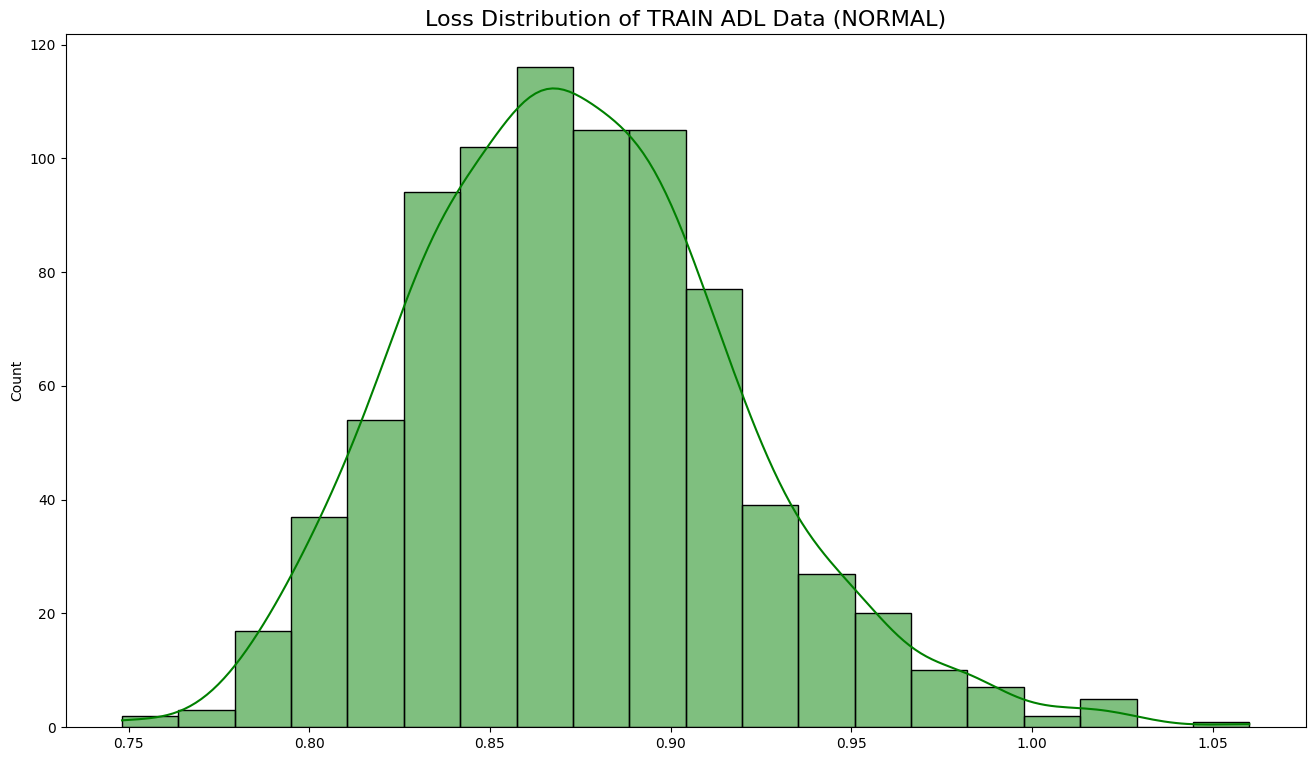

In [57]:
train_dataset = UMAFallDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

train_anomalies, train_scores, _ = detect_anomalies(model, ddpm, train_loader, device)

plt.figure(figsize=(16,9))
plt.title('Loss Distribution of TRAIN ADL Data (NORMAL)', fontsize=16)
sns.histplot(train_scores, bins=20, kde=True, color='green')
plt.show()

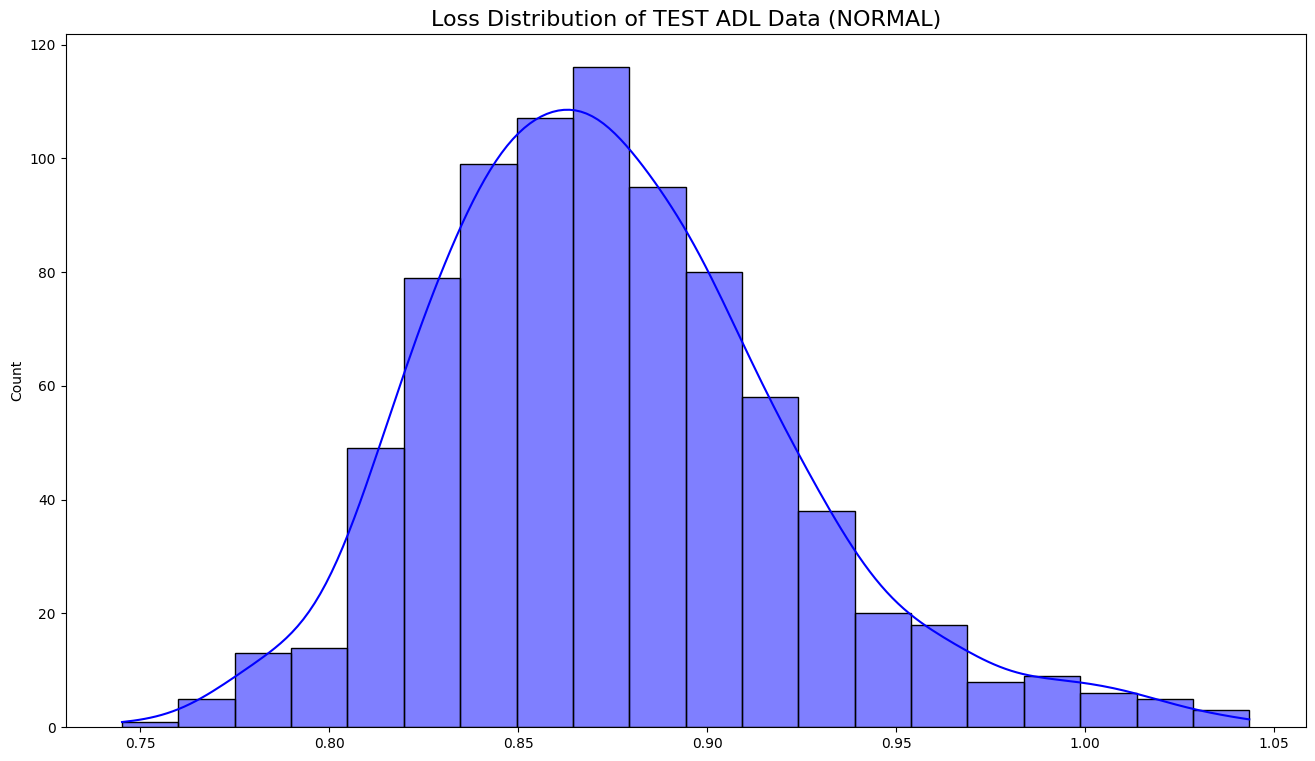

In [58]:
normal_anomalies, normal_scores, _ = detect_anomalies(model, ddpm, normal_loader, device)

plt.figure(figsize=(16,9))
plt.title('Loss Distribution of TEST ADL Data (NORMAL)', fontsize=16)
sns.histplot(normal_scores, bins=20, kde=True, color='blue')
plt.show()

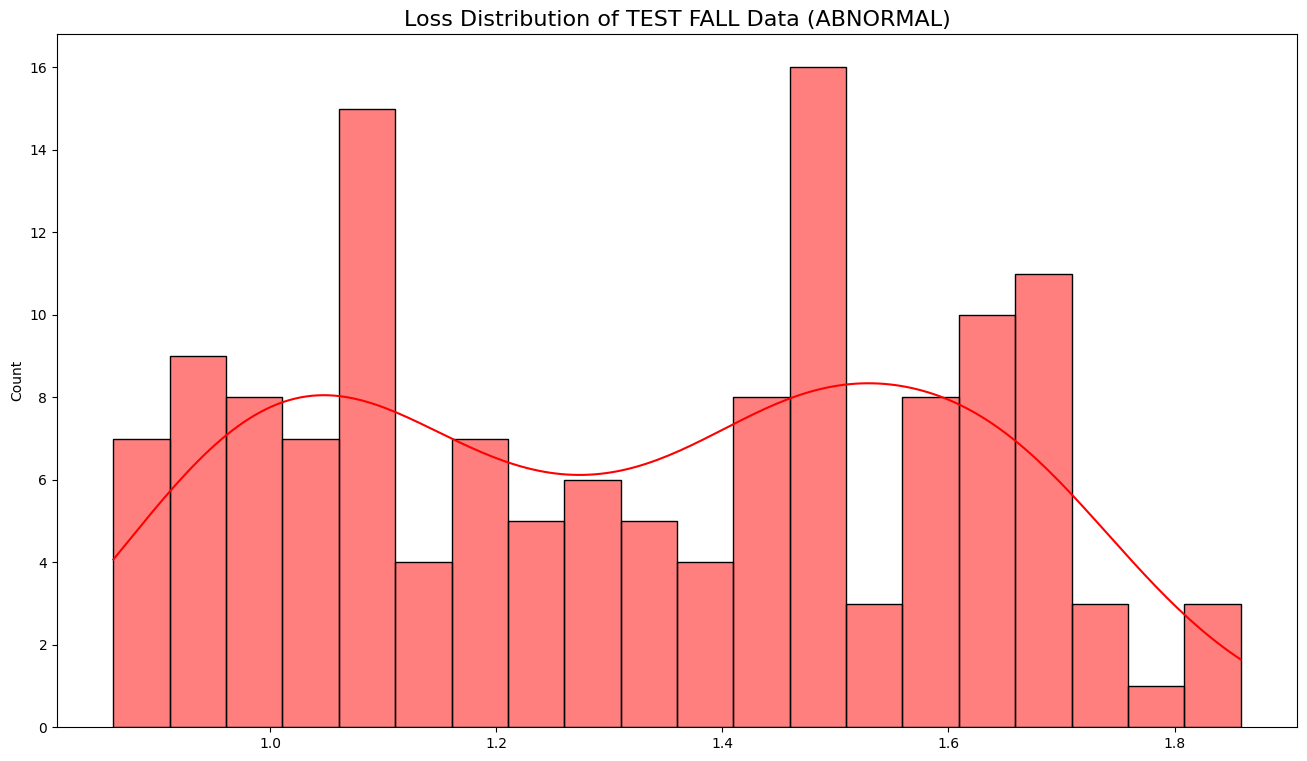

In [59]:
abnormal_anomalies, abnormal_scores, _ = detect_anomalies(model, ddpm, abnormal_loader, device)

plt.figure(figsize=(16,9))
plt.title('Loss Distribution of TEST FALL Data (ABNORMAL)', fontsize=16)
sns.histplot(abnormal_scores, bins=20, kde=True, color='red')
plt.show()

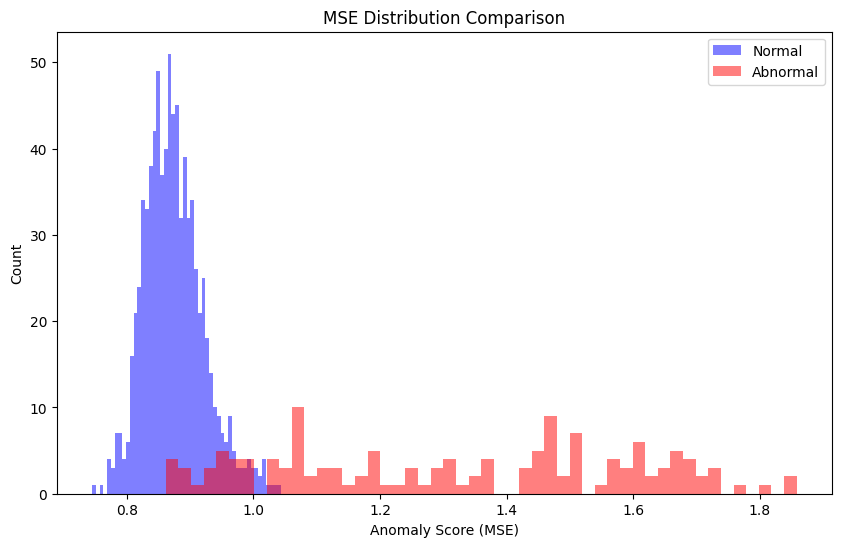

In [60]:
plt.figure(figsize=(10,6))
plt.title('MSE Distribution Comparison')
plt.hist(normal_scores, bins=50, alpha=0.5, color='blue', label='Normal')
plt.hist(abnormal_scores, bins=50, alpha=0.5, color='red', label='Abnormal')
plt.xlabel('Anomaly Score (MSE)')
plt.ylabel('Count')
plt.legend()
plt.show()

In [61]:
error_df = pd.DataFrame({
    'reconstruction_error': np.concatenate([normal_scores, abnormal_scores]),
    'true_class': np.concatenate([np.zeros(len(normal_scores)), np.ones(len(abnormal_scores))])
})

print ("error dataframe head : ")
print(error_df.head(10))
print ()
print ("error dataframe tail : ")
print(error_df.tail(10))
print ()
print(error_df.describe())
print ()
error_df['true_class'].value_counts()

error dataframe head : 
   reconstruction_error  true_class
0              0.870848         0.0
1              0.834160         0.0
2              0.832574         0.0
3              0.855064         0.0
4              0.901213         0.0
5              0.826974         0.0
6              0.877552         0.0
7              0.832271         0.0
8              0.839285         0.0
9              0.866160         0.0

error dataframe tail : 
     reconstruction_error  true_class
953              1.598676         1.0
954              1.303246         1.0
955              1.132777         1.0
956              1.032120         1.0
957              1.103737         1.0
958              1.080061         1.0
959              1.079786         1.0
960              0.920041         1.0
961              1.294259         1.0
962              1.230268         1.0

       reconstruction_error  true_class
count            963.000000  963.000000
mean               0.938799    0.145379
std             

true_class
0.0    823
1.0    140
Name: count, dtype: int64

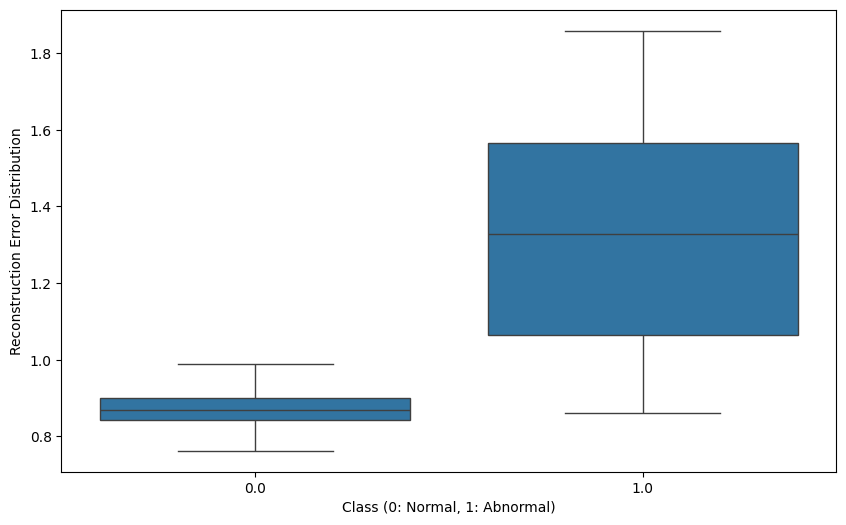

In [62]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='true_class', y='reconstruction_error', data=error_df, showfliers=False)
plt.ylabel('Reconstruction Error Distribution')
plt.xlabel('Class (0: Normal, 1: Abnormal)')
plt.show()

In [63]:
threshold = np.percentile(normal_scores, 80)

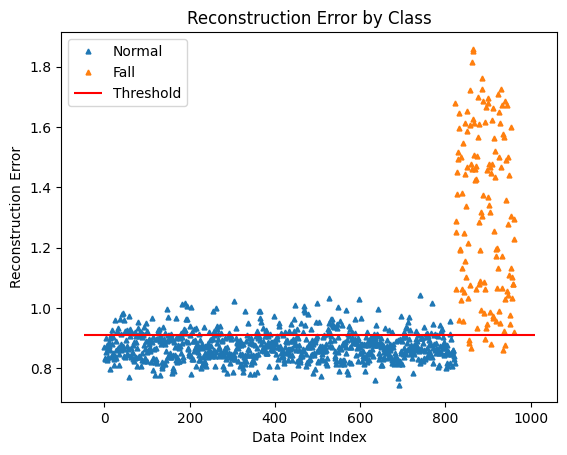

In [64]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
            label="Normal" if name == 0 else "Fall")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction Error by Class")
plt.ylabel("Reconstruction Error")
plt.xlabel("Data Point Index")
plt.show()

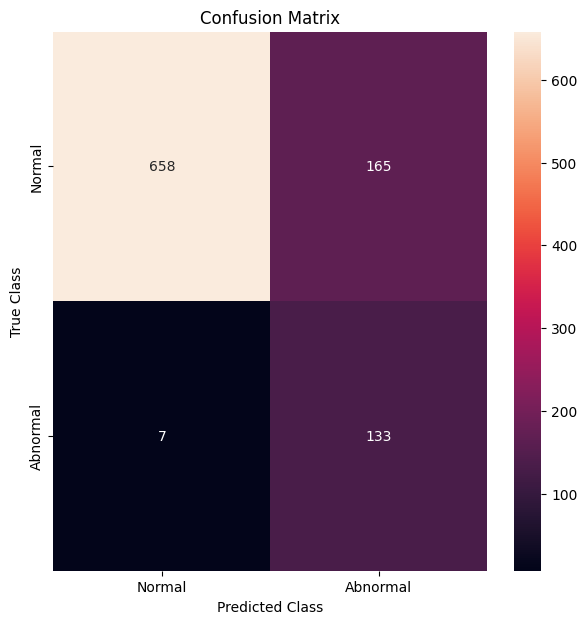

In [65]:
LABELS = ["Normal", "Abnormal"]
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(7, 7))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [66]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(error_df.true_class, y_pred, average='binary')
accuracy = accuracy_score(error_df.true_class, y_pred)

print('\nPerformance Metrics:')
print(f'Accuracy Score : {accuracy:.4f}')
print(f'Precision     : {precision:.4f}')
print(f'Recall        : {recall:.4f}')
print(f'F1 Score      : {f1:.4f}')


Performance Metrics:
Accuracy Score : 0.8214
Precision     : 0.4463
Recall        : 0.9500
F1 Score      : 0.6073
